# Knowledge graph data analysis

Gene sets to use:

Proteomics regression results

- d_HbA1C regression (LassoCV)
- d_HbA1C classification nonzero weights (LogRegLasso)
- current HbA1C regression weights (LassoCV)
- differential expression for HbA1C > 6.5 vs normal
- differential expression for d_HbA1C > 5% vs normal

In [4]:
# imports
import numpy as np
import pandas as pd
import networkx as nx
import kgfe
import matplotlib.pyplot as plt

from importlib import reload
reload(kgfe)

<module 'kgfe' from '/home/yjzhang/isb/kg_feature_engineering/src/kgfe/__init__.py'>

## 1. Load SPOKE-2021

In [5]:
spoke_graph_ud = kgfe.spoke_loader.load_spoke_igraph('../../graph_utils/spoke_2021.jsonl.gz', directed=False,
                                                    verbose=False)

In [6]:
spoke_graph_ud.to_undirected(combine_edges='first')
spoke_graph_ud.simplify(combine_edges='first')
spoke_graph_ud_connected = kgfe.graph_info.largest_component(spoke_graph_ud)

In [7]:
names_to_ids = kgfe.graph_info.get_names_to_ids(spoke_graph_ud_connected)

In [8]:
uniprot_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud_connected, 'Protein')

In [9]:
genes_to_ids = kgfe.graph_info.spoke_identifiers_to_ids(spoke_graph_ud_connected, 'Gene')

In [10]:
t2d_node_id = names_to_ids['type 2 diabetes mellitus']

In [11]:
ckd_node_id = names_to_ids['chronic kidney disease']

In [12]:
metformin_id = names_to_ids['Metformin']

In [13]:
glp_agonist_ids = [names_to_ids[x] for x in ['Semaglutide', 'DULAGLUTIDE', 'EXENATIDE', 'LIRAGLUTIDE', 'TIRZEPATIDE']
                  if x in names_to_ids]

In [14]:
sglp_inhibitor_ids = [names_to_ids[x] for x in ['Canagliflozin', 'Dapagliflozin', 'Empagliflozin']
                  if x in names_to_ids]

In [15]:
other_t2d_drug_ids =  [names_to_ids[x] for x in ['Acarbose', 'Metformin', 'Glimepiride']
                  if x in names_to_ids]

In [16]:
all_t2d_drug_ids = glp_agonist_ids + sglp_inhibitor_ids + other_t2d_drug_ids

## 2. Load datasets (LASSO parameters)

In [17]:
prot_regression_weights = pd.read_csv('results_2023_10_18/prots_lassocv_weights.csv')

In [18]:
prot_classification_weights = pd.read_csv('results_2023_10_18/prots_classification_lasso_weights.csv')

In [19]:
prot_names = pd.read_csv('../arivale_data/arivale_prots.tsv', sep='\t')

In [20]:
prot_names.index = prot_names['index']

### a) dHbA1C regression LassoCV weights

In [21]:
columns_to_exclude = set(['alpha', 'r2_score', 'target', 'current', 'intercept', 'C', 'balanced_accuracy_score', 'f1_score'])

In [22]:
weights_next_hba1c = prot_regression_weights.loc[prot_regression_weights.target=='d_hba1c', prot_regression_weights.columns!='target']
nonzero_weights = (weights_next_hba1c != 0).all(0)
weights_nonzeros = weights_next_hba1c.loc[:, nonzero_weights]

# TODO: separate positive and negative weights?
positive_weights = weights_next_hba1c.loc[:, (weights_next_hba1c > 0).all(0)]
negative_weights = weights_next_hba1c.loc[:, (weights_next_hba1c < 0).all(0)]

In [23]:
positive_regression_d_hba1c_prots = [x for x in positive_weights.columns if x not in columns_to_exclude]
hba1c_regression_uniprot_ids = prot_names.loc[positive_regression_d_hba1c_prots].uniprot.tolist()

In [24]:
negative_regression_d_hba1c_prots = [x for x in negative_weights.columns if x not in columns_to_exclude]
hba1c_regression_negative_uniprot_ids = prot_names.loc[negative_regression_d_hba1c_prots].uniprot.tolist()

In [25]:
print(len(hba1c_regression_uniprot_ids), len(hba1c_regression_negative_uniprot_ids))

22 25


In [26]:
set(hba1c_regression_uniprot_ids).intersection(hba1c_regression_negative_uniprot_ids)

set()

In [27]:
hba1c_regression_spoke_ids = [uniprot_to_ids[x] for x in hba1c_regression_uniprot_ids if x in uniprot_to_ids]

### b) dHbA1C classification LassoCV weights

In [316]:
weights_next_hba1c = prot_classification_weights.loc[prot_classification_weights.target=='d_class_hba1c', prot_classification_weights.columns!='target']

positive_weights = weights_next_hba1c.loc[:, (weights_next_hba1c > 0).all(0)]
negative_weights = weights_next_hba1c.loc[:, (weights_next_hba1c < 0).all(0)]

In [317]:
# identify a smaller subset of nodes? just have the 10 highest-ranked nodes.
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]

In [318]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values(ascending=False)

negative_weights_means = negative_weights.mean(0)
negative_weights_means = negative_weights_means.sort_values()

In [319]:
positive_class_d_hba1c_prots = weights_means.index
hba1c_class_uniprot_ids = prot_names.loc[positive_class_d_hba1c_prots].uniprot.tolist()

In [320]:
negative_class_d_hba1c_prots = negative_weights_means.index
hba1c_class_negative_uniprot_ids = prot_names.loc[negative_class_d_hba1c_prots].uniprot.tolist()

In [321]:
print(len(hba1c_class_uniprot_ids), len(hba1c_class_negative_uniprot_ids))

52 39


In [322]:
set(positive_class_d_hba1c_prots).intersection(negative_class_d_hba1c_prots)

set()

In [323]:
hba1c_class_spoke_ids = [uniprot_to_ids[x] for x in hba1c_class_uniprot_ids if x in uniprot_to_ids]

In [324]:
positive_class_d_hba1c_prots

Index(['INF_O15169', 'INF_P01137', 'CVD2_P01127', 'CVD2_P02760', 'INF_P13725',
       'CVD2_Q9Y6K9', 'CVD2_Q12866', 'CVD3_P14778', 'CVD3_Q12860',
       'CVD2_P51161', 'CVD2_Q9BQ51', 'CVD2_Q99523', 'CVD3_P30530',
       'CVD3_P15085', 'CVD2_Q14005', 'CVD2_Q9UIB8', 'INF_P51671',
       'CVD3_P05107', 'CVD2_P09237', 'CVD3_P33151', 'CVD3_Q03405',
       'CVD2_P26022', 'INF_P78556', 'CVD2_P07711', 'INF_P13236', 'INF_Q07011',
       'CVD3_P24158', 'CVD3_P01130', 'CVD3_P28799', 'INF_Q5T4W7', 'INF_P29460',
       'INF_P39905', 'INF_P80098', 'INF_P42830', 'CVD3_Q13231', 'CVD3_P80370',
       'CVD2_O43915', 'CVD3_P07339', 'INF_Q8WWJ7', 'CVD3_Q16663',
       'CVD3_P78324', 'CVD2_P39900', 'INF_P01583', 'CVD2_P09601',
       'CVD3_P19957', 'INF_P01138', 'CVD3_NT-proBNP', 'CVD2_Q15109',
       'CVD2_P31994', 'INF_Q9NYY1', 'INF_P22301', 'CVD3_P16581'],
      dtype='object')

In [325]:
hba1c_class_top_ids = weights_means[:10].index
hba1c_class_top_uniprot_ids = prot_names.loc[hba1c_class_top_ids].uniprot.tolist()
hba1c_class_top_spoke_ids = [uniprot_to_ids[x] for x in hba1c_class_top_uniprot_ids if x in uniprot_to_ids]

In [326]:
len(hba1c_class_top_spoke_ids)

10

In [327]:
positive_weights

CVD2_O43915  CVD2_P01127  CVD2_P02760  CVD2_P07711  CVD2_P09237  \
0     0.308533     0.310510     0.473292     0.389249     0.321790   
1     0.290578     0.532062     0.631481     0.392829     0.210138   
2     0.199383     0.714124     0.556209     0.316168     0.351145   
3     0.321296     0.643203     0.470311     0.165047     0.275220   
4     0.135838     0.969430     0.508079     0.290509     0.437455   
5     0.164125     0.560169     0.462545     0.368567     0.366728   
6     0.118839     0.628772     0.727149     0.147595     0.095123   
7     0.181913     0.666199     0.581603     0.413214     0.331012   
8     0.178767     0.865256     0.711004     0.242440     0.673922   
9     0.129370     0.516953     0.481730     0.289718     0.349709   

   CVD2_P09601  CVD2_P26022  CVD2_P31994  CVD2_P39900  CVD2_P51161  ...  \
0     0.081567     0.340775     0.045929     0.191390     0.388341  ...   
1     0.215608     0.265879     0.170802     0.112322     0.301704  ...   
2     0.036966     0.205295     0.099879     0.057819     0.433087  ...   
3     0.166939     0.367739     0.126441     0.307458     0.380467  ...   
4     0.346077     0.214418     0.140456     0.133826     0.406509  ...   
5     0.116998     0.267580     0.081862     0.170681     0.380342  ...   
6     0.109139     0.699155     0.025914     0.328855     0.503937  ...   
7     0.303415     0.308230     0.120643     0.177362     0.600623  ...   
8     0.071676     0.270772     0.129827     0.122924     0.484623  ...   
9     0.216802     0.225687     0.151774     0.164726     0.390244  ...   

   INF_P29460  INF_P39905  INF_P42830  INF_P51671  INF_P78556  INF_P80098  \
0    0.261193    0.122726    0.218206    0.305424    0.460466    0.376037   
1    0.250215    0.297718    0.348377    0.268256    0.221508    0.208094   
2    0.297108    0.294687    0.134196    0.341895    0.332556    0.226422   
3    0.361230    0.353745    0.213450    0.225871    0.289126    0.281227   
4    0.255209    0.305894    0.357864    0.362732    0.302476    0.274022   
5    0.312495    0.173888    0.209290    0.489331    0.297801    0.139037   
6    0.096368    0.360149    0.278344    0.352793    0.203077    0.128059   
7    0.380246    0.186272    0.303231    0.555430    0.244899    0.265271   
8    0.136765    0.228913    0.074559    0.545998    0.515158    0.250117   
9    0.289964    0.285663    0.264304    0.227305    0.288760    0.303859   

   INF_Q07011  INF_Q5T4W7  INF_Q8WWJ7  INF_Q9NYY1  
0    0.334677    0.313816    0.224977    0.045295  
1    0.293551    0.221295    0.187405    0.136634  
2    0.135108    0.255747    0.174906    0.043742  
3    0.245271    0.205480    0.057772    0.035608  
4    0.289564    0.317491    0.187252    0.156614  
5    0.257843    0.284705    0.283533    0.242461  
6    0.529011    0.458474    0.261167    0.139989  
7    0.245566    0.305492    0.231390    0.117476  
8    0.389645    0.268510    0.085115    0.043669  
9    0.209061    0.141932    0.264141    0.130804  

[10 rows x 52 columns]

#### Plotting top proteins

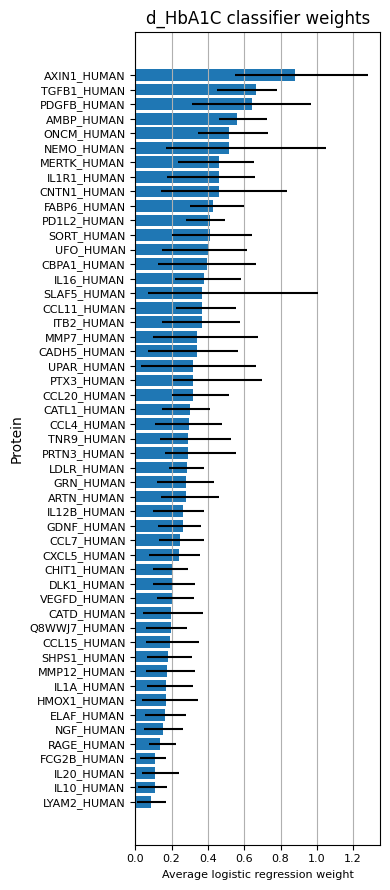

In [328]:
# TODO: plot top 10 proteins?
weights_means = positive_weights.mean(0)
weights_std = positive_weights.std(0)
weights_means = weights_means.sort_values()
weights_means = weights_means[[x for x in weights_means.index if prot_names.loc[x].uniprot in uniprot_to_ids]]

positive_weights = positive_weights.loc[:, weights_means.index]

weights_std = positive_weights.std(0)
weights_max = positive_weights.max(0) - weights_means
weights_min = weights_means - positive_weights.min(0)

ranges = np.vstack([weights_min, weights_max])
uniprots = prot_names.loc[weights_means.index].uniprot.tolist()
spoke_ids = [uniprot_to_ids[x] for x in uniprots if x in uniprot_to_ids]
protein_feature_names = [spoke_graph_ud_connected.vs.find(name=x)['feature_name'] for x in spoke_ids]
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 9))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names, weights_means, xerr=ranges)
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_hba1c_all_proteins.png', dpi=300)

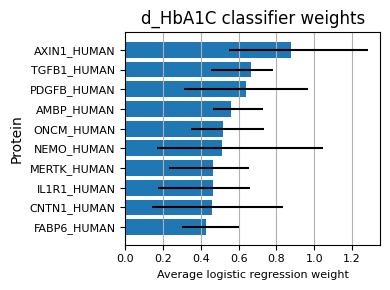

In [329]:
# plotting top 10 proteins
fig, ax = plt.subplots(figsize=(4, 3))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names[-10:], weights_means[-10:], xerr=ranges[:, -10:])
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_hba1c_top10_proteins.png', dpi=300)

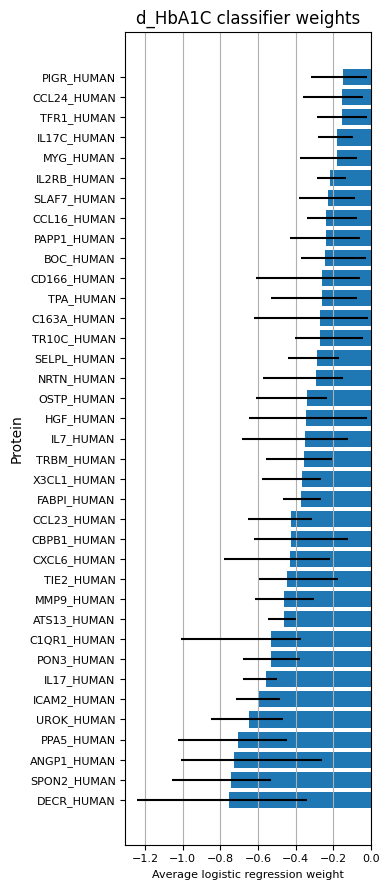

In [330]:
# plot negatively weighted proteins
weights_means = negative_weights.mean(0)
weights_std = negative_weights.std(0)
weights_means = weights_means.sort_values()
weights_means = weights_means[[x for x in weights_means.index if prot_names.loc[x].uniprot in uniprot_to_ids]]

negative_weights = negative_weights.loc[:, weights_means.index]

weights_std = negative_weights.std(0)
weights_max = negative_weights.max(0) - weights_means
weights_min = weights_means - negative_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

uniprots = prot_names.loc[weights_means.index].uniprot.tolist()
spoke_ids = [uniprot_to_ids[x] for x in uniprots if x in uniprot_to_ids]
protein_feature_names = [spoke_graph_ud_connected.vs.find(name=x)['feature_name'] for x in spoke_ids]

fig, ax = plt.subplots(figsize=(4, 9))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names, weights_means, xerr=ranges)
plt.title('d_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_hba1c_all_proteins_negative.png', dpi=300)

In [331]:
negative_weights.columns

Index(['CVD2_Q16698', 'CVD2_Q9BUD6', 'CVD2_Q15389', 'CVD3_P13686',
       'CVD3_P00749', 'CVD3_P13598', 'INF_Q16552', 'CVD3_Q15166',
       'CVD3_Q9NPY3', 'CVD2_Q76LX8', 'CVD3_P14780', 'CVD2_Q02763',
       'INF_P80162', 'CVD3_P15086', 'INF_P55773', 'CVD2_P12104', 'INF_P78423',
       'CVD2_P07204', 'INF_P13232', 'INF_P14210', 'CVD3_P10451', 'INF_Q99748',
       'CVD2_Q14242', 'CVD3_O14798', 'CVD3_Q86VB7', 'CVD3_P00750',
       'CVD3_Q13740', 'CVD2_Q9BWV1', 'CVD2_Q13219', 'CVD3_O15467',
       'CVD2_Q9NQ25', 'INF_P14784', 'CVD3_P02144', 'INF_Q9P0M4', 'CVD3_P02786',
       'CVD3_O00175', 'CVD2_P01833'],
      dtype='object')

#### Converted to genes

In [332]:
from kgfe import gene_names

In [333]:
hba1c_class_positive_gene_symbols = prot_names.loc[positive_class_d_hba1c_prots].gene_name.tolist()

In [334]:
hba1c_class_positive_gene_ids = gene_names.get_ids(hba1c_class_positive_gene_symbols)
hba1c_class_gene_spoke_ids = [genes_to_ids[x] for x in hba1c_class_positive_gene_ids if x in genes_to_ids]

In [335]:
len(hba1c_class_gene_spoke_ids)

51

In [336]:
hba1c_class_top_gene_symbols = prot_names.loc[hba1c_class_top_ids].gene_name.tolist()

In [337]:
hba1c_class_top_gene_ids = gene_names.get_ids(prot_names.loc[hba1c_class_top_ids].gene_name.tolist())
hba1c_class_top_gene_spoke_ids = [genes_to_ids[x] for x in hba1c_class_top_gene_ids if x in genes_to_ids]

In [338]:
hba1c_class_top_gene_spoke_ids

['2196237',
 '2195372',
 '2193833',
 '2190095',
 '2193711',
 '2196405',
 '2198052',
 '2192603',
 '2190903',
 '2191598']

#### dHbA1C weights - 1 year

In [339]:
weights_next_hba1c = prot_classification_weights.loc[prot_classification_weights.target=='d_class_1y_hba1c', prot_classification_weights.columns!='target']

positive_weights = weights_next_hba1c.loc[:, (weights_next_hba1c > 0).all(0)]
negative_weights = weights_next_hba1c.loc[:, (weights_next_hba1c < 0).all(0)]

In [340]:
# identify a smaller subset of nodes? just have the 10 highest-ranked nodes.
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]

In [341]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values(ascending=False)

negative_weights_means = negative_weights.mean(0)
negative_weights_means = negative_weights_means.sort_values()

In [342]:
positive_class_1y_d_hba1c_prots = weights_means.index
hba1c_class_1y_uniprot_ids = prot_names.loc[positive_class_1y_d_hba1c_prots].uniprot.tolist()

In [343]:
negative_class_1y_d_hba1c_prots = negative_weights_means.index
hba1c_class_1y_negative_uniprot_ids = prot_names.loc[negative_class_1y_d_hba1c_prots].uniprot.tolist()

In [344]:
print(len(hba1c_class_1y_uniprot_ids), len(hba1c_class_1y_negative_uniprot_ids))

26 30


In [345]:
hba1c_class_1y_spoke_ids = [uniprot_to_ids[x] for x in hba1c_class_1y_uniprot_ids if x in uniprot_to_ids]

In [346]:
hba1c_class_1y_top_ids = weights_means[:10].index
hba1c_class_1y_top_uniprot_ids = prot_names.loc[hba1c_class_1y_top_ids].uniprot.tolist()
hba1c_class_1y_top_spoke_ids = [uniprot_to_ids[x] for x in hba1c_class_1y_top_uniprot_ids if x in uniprot_to_ids]

In [347]:
positive_weights

CVD2_P01730  CVD2_P07585  CVD2_P21980  CVD2_Q14005  CVD2_Q14116  \
10     0.249808     0.305888     0.176561     0.346791     0.392577   
11     0.087849     0.109451     0.196208     0.707150     0.471031   
12     0.167056     0.291562     0.298283     0.361111     0.376321   
13     0.214984     0.250418     0.064853     0.631837     0.768250   
14     0.049448     0.503654     0.160075     0.567846     0.638641   
15     0.231234     0.435416     0.223922     0.542487     0.237574   
16     0.456167     0.268311     0.344177     0.389953     0.737753   
17     0.105960     0.170617     0.287964     0.611626     0.385550   
18     0.338455     0.082938     0.102580     0.304116     0.586829   
19     0.298813     0.320822     0.233555     0.475379     0.736048   

    CVD2_Q96D42  CVD2_Q9HB29  CVD2_Q9Y6K9  CVD2_Q9Y6Q6  CVD3_P02452  ...  \
10     0.340644     0.275287     0.621795     1.025011     0.165041  ...   
11     0.377453     0.332621     0.598333     0.519468     0.048422  ...   
12     0.285581     0.311838     0.474629     0.675768     0.134868  ...   
13     0.485374     0.316810     0.141931     0.782975     0.294554  ...   
14     0.519012     0.172422     0.568634     1.141399     0.145740  ...   
15     0.607043     0.244002     0.202945     0.454155     0.333782  ...   
16     0.407977     0.133190     0.400001     0.887847     0.034420  ...   
17     0.326450     0.303995     0.521564     0.423982     0.196540  ...   
18     0.382054     0.306380     0.638451     0.944955     0.101455  ...   
19     0.528722     0.163798     0.729917     0.901993     0.366340  ...   

    INF_P01579  INF_P03956  INF_P20783  INF_P42702  INF_P78556  INF_P80098  \
10    0.362968    0.230343    0.424354    0.535329    1.332446    0.136635   
11    0.199749    0.281849    0.132593    0.271133    0.940046    0.163334   
12    0.295124    0.737725    0.348098    0.506846    1.180801    0.177870   
13    0.374371    0.329084    0.157173    0.374985    1.183113    0.365652   
14    0.345658    0.242850    0.253414    0.376137    1.032625    0.458411   
15    0.264457    0.206890    0.016745    0.269602    1.221827    0.469177   
16    0.300751    0.282932    0.290563    0.673409    0.994661    0.387985   
17    0.013691    0.391062    0.306930    0.229176    0.915223    0.221284   
18    0.372944    0.288670    0.396373    0.323657    1.192441    0.374181   
19    0.305886    0.325196    0.369552    0.241759    1.187902    0.338906   

    INF_Q13291  INF_Q8WWJ7  INF_Q9NRJ3  INF_Q9NYY1  
10    0.164035    0.543410    0.505789    0.495173  
11    0.297355    0.436145    0.849800    0.614298  
12    0.153796    0.684014    0.731151    0.388434  
13    0.228859    0.738311    0.757446    0.322955  
14    0.059131    0.668181    0.658326    0.407209  
15    0.538501    0.544128    0.422509    0.413985  
16    0.430856    0.300284    0.515505    0.339160  
17    0.172810    0.571189    0.532776    0.449122  
18    0.309023    0.548361    0.866206    0.373847  
19    0.097870    1.002925    0.666868    0.442389  

[10 rows x 26 columns]

#### Plotting top proteins (1y)

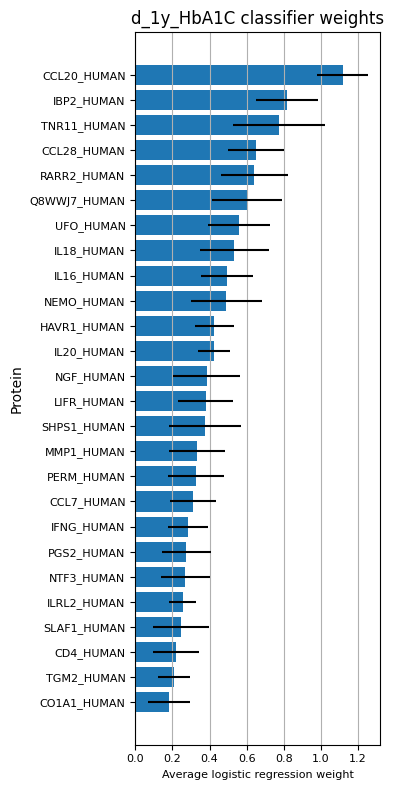

In [348]:
# TODO: plot top 10 proteins?
weights_means = positive_weights.mean(0)
weights_std = positive_weights.std(0)
weights_means = weights_means.sort_values()
weights_means = weights_means[[x for x in weights_means.index if prot_names.loc[x].uniprot in uniprot_to_ids]]
weights_std = weights_std[weights_means.index]
uniprots = prot_names.loc[weights_means.index].uniprot.tolist()
spoke_ids = [uniprot_to_ids[x] for x in uniprots if x in uniprot_to_ids]
protein_feature_names = [spoke_graph_ud_connected.vs.find(name=x)['feature_name'] for x in spoke_ids]
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 8))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names, weights_means, xerr=weights_std)
plt.title('d_1y_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_1y_hba1c_all_proteins.png', dpi=300)

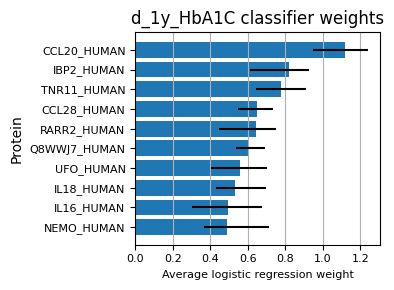

In [349]:
# TODO: plot top 10 proteins?
fig, ax = plt.subplots(figsize=(4, 3))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names[-10:], weights_means[-10:], xerr=ranges[:, -10:])
plt.title('d_1y_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_1y_hba1c_top10_proteins.png', dpi=300)

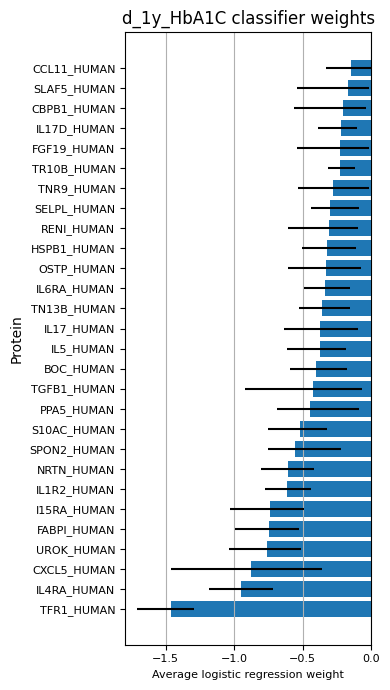

In [350]:
# TODO: plot top 10 proteins?
weights_means = negative_weights.mean(0)
weights_means = weights_means.sort_values()
weights_means = weights_means[[x for x in weights_means.index if prot_names.loc[x].uniprot in uniprot_to_ids]]

negative_weights = negative_weights.loc[:, weights_means.index]

weights_std = negative_weights.std(0)
weights_max = negative_weights.max(0) - weights_means
weights_min = weights_means - negative_weights.min(0)

ranges = np.vstack([weights_min, weights_max])
uniprots = prot_names.loc[weights_means.index].uniprot.tolist()
spoke_ids = [uniprot_to_ids[x] for x in uniprots if x in uniprot_to_ids]
protein_feature_names = [spoke_graph_ud_connected.vs.find(name=x)['feature_name'] for x in spoke_ids]
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 7))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names, weights_means, xerr=ranges)
plt.title('d_1y_HbA1C classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_1y_hba1c_all_proteins_negative.png', dpi=300)

### c) current-HbA1C regression LassoCV weights

In [351]:
weights_current_hba1c = prot_regression_weights.loc[prot_regression_weights.target=='HbA1C', prot_regression_weights.columns!='target']
nonzero_weights = (weights_current_hba1c != 0).all(0)
weights_nonzeros = weights_current_hba1c.loc[:, nonzero_weights]

# TODO: separate positive and negative weights?
positive_weights = weights_current_hba1c.loc[:, (weights_current_hba1c > 0).all(0)]
negative_weights = weights_current_hba1c.loc[:, (weights_current_hba1c < 0).all(0)]

In [352]:
positive_regression_hba1c_prots = [x for x in positive_weights.columns if x not in columns_to_exclude]
current_hba1c_regression_uniprot_ids = prot_names.loc[positive_regression_hba1c_prots].uniprot.tolist()

In [353]:
negative_regression_hba1c_prots = [x for x in negative_weights.columns if x not in columns_to_exclude]
current_hba1c_regression_negative_uniprot_ids = prot_names.loc[negative_regression_hba1c_prots].uniprot.tolist()

In [354]:
print(len(current_hba1c_regression_uniprot_ids), len(current_hba1c_regression_negative_uniprot_ids))

36 39


In [355]:
current_hba1c_regression_spoke_ids = [uniprot_to_ids[x] for x in current_hba1c_regression_uniprot_ids if x in uniprot_to_ids]

### d) dGFR classification LassoCV weights

In [379]:
weights_next_gfr = prot_classification_weights.loc[prot_classification_weights.target=='d_class_gfr', prot_classification_weights.columns!='target']

positive_weights = weights_next_gfr.loc[:, (weights_next_gfr > 0).all(0)]
negative_weights = weights_next_gfr.loc[:, (weights_next_gfr < 0).all(0)]

In [380]:
positive_class_d_gfr_prots = [x for x in positive_weights.columns if x not in columns_to_exclude]
gfr_class_uniprot_ids = prot_names.loc[positive_class_d_gfr_prots].uniprot.tolist()

In [381]:
negative_class_d_gfr_prots = [x for x in negative_weights.columns if x not in columns_to_exclude]
gfr_class_negative_uniprot_ids = prot_names.loc[negative_class_d_gfr_prots].uniprot.tolist()

In [382]:
print(len(gfr_class_uniprot_ids), len(gfr_class_negative_uniprot_ids))

53 50


In [383]:
gfr_class_spoke_ids = [uniprot_to_ids[x] for x in gfr_class_uniprot_ids if x in uniprot_to_ids]

In [384]:
# TODO: identify a smaller subset of nodes? just have the 10 highest-ranked nodes.
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]

In [385]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values(ascending=False)

In [386]:
gfr_class_top_ids = weights_means[:10].index
gfr_class_top_uniprot_ids = prot_names.loc[gfr_class_top_ids].uniprot.tolist()
gfr_class_top_spoke_ids = [uniprot_to_ids[x] for x in gfr_class_top_uniprot_ids if x in uniprot_to_ids]

In [387]:
len(gfr_class_top_spoke_ids)

10

#### Plotting top proteins

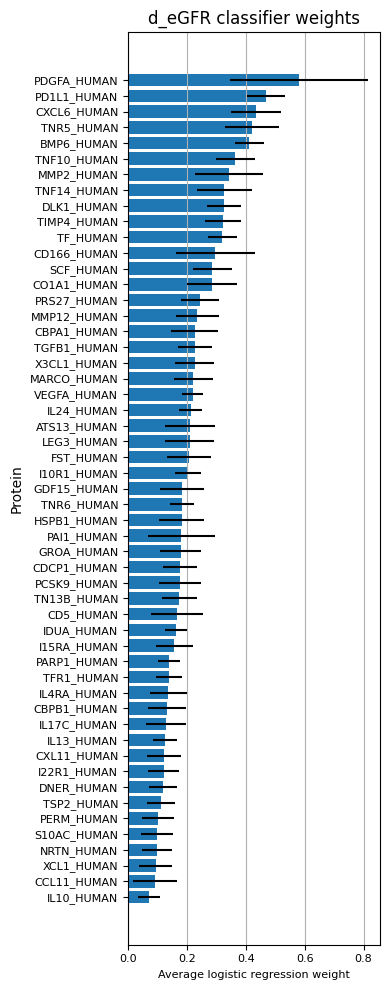

In [389]:
# TODO: plot top 10 proteins?
weights_means = positive_weights.mean(0)
weights_std = positive_weights.std(0)
weights_means = weights_means.sort_values()
weights_means = weights_means[[x for x in weights_means.index if prot_names.loc[x].uniprot in uniprot_to_ids]]

positive_weights = positive_weights.loc[:, weights_means.index]

weights_std = positive_weights.std(0)
weights_max = positive_weights.max(0) - weights_means
weights_min = weights_means - positive_weights.min(0)

ranges = np.vstack([weights_min, weights_max])
uniprots = prot_names.loc[weights_means.index].uniprot.tolist()
spoke_ids = [uniprot_to_ids[x] for x in uniprots if x in uniprot_to_ids]
protein_feature_names = [spoke_graph_ud_connected.vs.find(name=x)['feature_name'] for x in spoke_ids]
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 10))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names, weights_means, xerr=weights_std)
plt.title('d_eGFR classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_gfr_all_proteins.png', dpi=300)

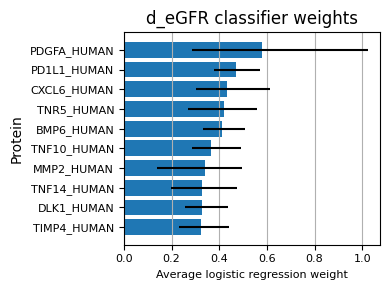

In [390]:
# plot top 10 proteins?
fig, ax = plt.subplots(figsize=(4, 3))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names[-10:], weights_means[-10:], xerr=ranges[:, -10:])
plt.title('d_eGFR classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_gfr_top10_proteins.png', dpi=300)

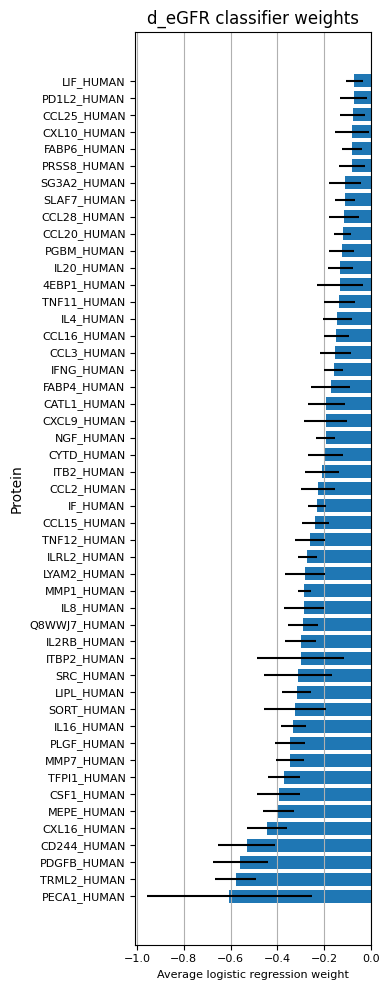

In [392]:
# plot negative proteins
weights_means = negative_weights.mean(0)
weights_std = negative_weights.std(0)
weights_means = weights_means.sort_values()
weights_means = weights_means[[x for x in weights_means.index if x in prot_names['index'] and prot_names.loc[x].uniprot in uniprot_to_ids]]

negative_weights = negative_weights.loc[:, weights_means.index]

weights_std = negative_weights.std(0)
weights_max = negative_weights.max(0) - weights_means
weights_min = weights_means - negative_weights.min(0)

ranges = np.vstack([weights_min, weights_max])

uniprots = prot_names.loc[weights_means.index].uniprot.tolist()
spoke_ids = [uniprot_to_ids[x] for x in uniprots if x in uniprot_to_ids]
protein_feature_names = [spoke_graph_ud_connected.vs.find(name=x)['feature_name'] for x in spoke_ids]

fig, ax = plt.subplots(figsize=(4, 10))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names, weights_means, xerr=weights_std)
plt.title('d_eGFR classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_gfr_all_proteins_negative.png', dpi=300)

#### Converted to genes

In [393]:
gfr_class_positive_gene_symbols = prot_names.loc[positive_class_d_gfr_prots].gene_name.tolist()

In [394]:
gfr_class_positive_gene_ids = gene_names.get_ids(gfr_class_positive_gene_symbols)
gfr_class_gene_spoke_ids = [genes_to_ids[x] for x in gfr_class_positive_gene_ids if x in genes_to_ids]

In [395]:
len(gfr_class_gene_spoke_ids)

53

In [396]:
gfr_class_top_gene_ids = gene_names.get_ids(prot_names.loc[gfr_class_top_ids].gene_name.tolist())
gfr_class_top_gene_spoke_ids = [genes_to_ids[x] for x in gfr_class_top_gene_ids if x in genes_to_ids]

In [397]:
gfr_class_top_gene_spoke_ids

['2193832',
 '2208382',
 '2194799',
 '2190665',
 '2190414',
 '2196595',
 '2193219',
 '2196592',
 '2196628',
 '2195410']

#### dGFR weights - 1 year

In [399]:
weights_next_gfr = prot_classification_weights.loc[prot_classification_weights.target=='d_class_1y_gfr', prot_classification_weights.columns!='target']

positive_weights = weights_next_gfr.loc[:, (weights_next_gfr > 0).all(0)]
negative_weights = weights_next_gfr.loc[:, (weights_next_gfr < 0).all(0)]

In [400]:
# identify a smaller subset of nodes? just have the 10 highest-ranked nodes.
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]
negative_weights = negative_weights.loc[:, (x for x in negative_weights.columns if x not in columns_to_exclude)]

In [401]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values(ascending=False)

negative_weights_means = negative_weights.mean(0)
negative_weights_means = negative_weights_means.sort_values()

In [402]:
positive_class_1y_d_gfr_prots = weights_means.index
gfr_class_1y_uniprot_ids = prot_names.loc[positive_class_1y_d_gfr_prots].uniprot.tolist()

In [403]:
negative_class_1y_d_gfr_prots = negative_weights_means.index
gfr_class_1y_negative_uniprot_ids = prot_names.loc[negative_class_1y_d_gfr_prots].uniprot.tolist()

In [404]:
print(len(gfr_class_1y_uniprot_ids), len(gfr_class_1y_negative_uniprot_ids))

43 49


In [405]:
gfr_class_1y_spoke_ids = [uniprot_to_ids[x] for x in gfr_class_1y_uniprot_ids if x in uniprot_to_ids]

In [406]:
gfr_class_1y_top_ids = weights_means[:10].index
gfr_class_1y_top_uniprot_ids = prot_names.loc[gfr_class_1y_top_ids].uniprot.tolist()
gfr_class_1y_top_spoke_ids = [uniprot_to_ids[x] for x in gfr_class_1y_top_uniprot_ids if x in uniprot_to_ids]

In [407]:
positive_weights

CVD2_O00182  CVD2_P07204  CVD2_P07585  CVD2_P13726  CVD2_P21583  \
30     0.302722     0.398171     0.909100     0.437810     0.701393   
31     0.289298     0.231721     0.842819     0.479801     0.494858   
32     0.279272     0.360668     0.740670     0.105533     0.657120   
33     0.413847     0.327291     0.958160     0.432117     0.667359   
34     0.254864     0.482920     0.558186     0.463175     0.576914   
35     0.344323     0.460257     0.771894     0.510464     0.848640   
36     0.459685     0.521923     0.796141     0.479410     0.544117   
37     0.201282     0.381188     0.994992     0.506298     0.744331   
38     0.612561     0.624023     0.864466     0.100291     0.558464   
39     0.274520     0.221743     0.777954     0.419927     0.810360   

    CVD2_P22004  CVD2_P24394  CVD2_P31994  CVD2_P31997  CVD2_P35318  ...  \
30     0.757038     0.570753     0.438334     0.659090     0.465677  ...   
31     0.322954     0.436172     0.323121     0.406569     0.263548  ...   
32     0.178770     0.446474     0.124479     0.412948     0.684150  ...   
33     0.565976     0.749129     0.311894     0.638018     0.299886  ...   
34     0.300432     0.581213     0.127606     0.345796     0.410573  ...   
35     0.062443     0.606861     0.114571     0.528401     0.392038  ...   
36     0.538547     0.543597     0.269348     0.660437     0.304069  ...   
37     0.344331     0.401925     0.197874     0.511476     0.383047  ...   
38     0.535360     0.289482     0.209678     0.627557     0.197092  ...   
39     0.276437     0.476618     0.262710     0.551149     0.207972  ...   

    INF_P14210  INF_P49771  INF_P50591  INF_P80162  INF_P80511  INF_Q08334  \
30    0.415503    0.448493    0.605050    0.599458    0.533299    0.646805   
31    0.476008    0.555192    0.392795    0.150773    0.713046    0.804801   
32    0.758947    0.382947    0.374554    0.773119    0.607414    0.907006   
33    0.646942    0.518429    0.318011    0.558815    0.618429    0.552966   
34    0.521649    0.682860    0.578837    0.237156    0.703299    0.705417   
35    0.446240    0.146156    0.619552    0.175729    0.684563    0.888567   
36    0.138949    0.468517    0.537111    0.620130    0.458530    0.784534   
37    0.499163    0.407718    0.577348    0.434784    0.697616    0.914441   
38    0.070446    0.497821    0.590175    0.481424    0.856066    0.918060   
39    0.394907    0.119226    0.534715    0.647984    0.666982    0.709477   

    INF_Q13261  INF_Q13478  INF_Q16552  INF_Q8N6P7  
30    0.083079    0.356265    0.491061    0.146816  
31    0.236915    0.403623    0.536594    0.161429  
32    0.084273    0.376270    0.558031    0.155108  
33    0.392418    0.487088    0.735923    0.163394  
34    0.203951    0.301005    0.301586    0.342974  
35    0.521922    0.199402    0.423513    0.254350  
36    0.440327    0.394634    0.495446    0.257920  
37    0.307044    0.292741    0.408747    0.304343  
38    0.153264    0.286532    0.587195    0.194644  
39    0.203856    0.222682    0.515007    0.360528  

[10 rows x 43 columns]

#### Plotting top proteins (1y)

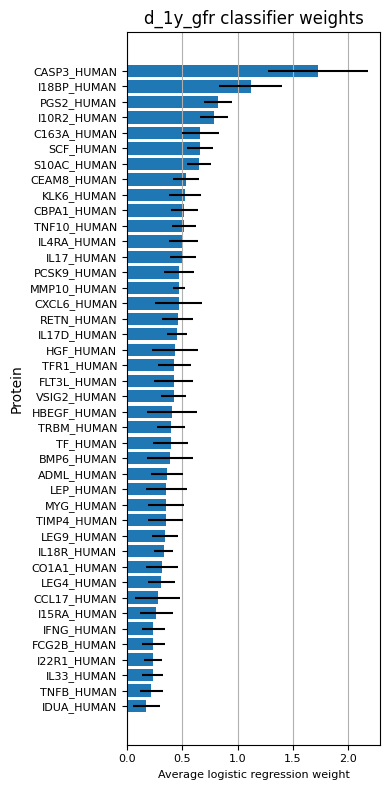

In [408]:
# TODO: plot top 10 proteins?
weights_means = positive_weights.mean(0)
weights_std = positive_weights.std(0)
weights_means = weights_means.sort_values()
weights_means = weights_means[[x for x in weights_means.index if prot_names.loc[x].uniprot in uniprot_to_ids]]
weights_std = weights_std[weights_means.index]
uniprots = prot_names.loc[weights_means.index].uniprot.tolist()
spoke_ids = [uniprot_to_ids[x] for x in uniprots if x in uniprot_to_ids]
protein_feature_names = [spoke_graph_ud_connected.vs.find(name=x)['feature_name'] for x in spoke_ids]
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 8))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names, weights_means, xerr=weights_std)
plt.title('d_1y_gfr classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_1y_gfr_all_proteins.png', dpi=300)

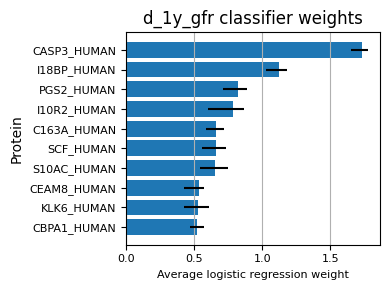

In [409]:
# TODO: plot top 10 proteins?
fig, ax = plt.subplots(figsize=(4, 3))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names[-10:], weights_means[-10:], xerr=ranges[:, -10:])
plt.title('d_1y_gfr classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_1y_gfr_top10_proteins.png', dpi=300)

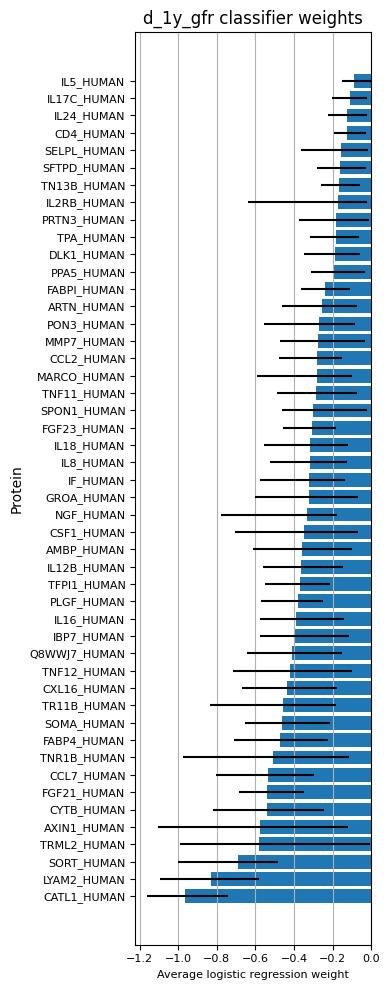

In [411]:
# TODO: plot top 10 proteins?
weights_means = negative_weights.mean(0)
weights_means = weights_means.sort_values()
weights_means = weights_means[[x for x in weights_means.index if prot_names.loc[x].uniprot in uniprot_to_ids]]

negative_weights = negative_weights.loc[:, weights_means.index]

weights_std = negative_weights.std(0)
weights_max = negative_weights.max(0) - weights_means
weights_min = weights_means - negative_weights.min(0)

ranges = np.vstack([weights_min, weights_max])
uniprots = prot_names.loc[weights_means.index].uniprot.tolist()
spoke_ids = [uniprot_to_ids[x] for x in uniprots if x in uniprot_to_ids]
protein_feature_names = [spoke_graph_ud_connected.vs.find(name=x)['feature_name'] for x in spoke_ids]
# TODO: plot the regression weights

fig, ax = plt.subplots(figsize=(4, 10))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh(protein_feature_names, weights_means, xerr=ranges)
plt.title('d_1y_gfr classifier weights')
ax.set_xlabel('Average logistic regression weight', fontsize=8)
ax.grid(axis='x')
ax.set_ylabel('Protein')
plt.tight_layout()
plt.savefig('images_2023_10_18/coefficients_d_class_1y_gfr_all_proteins_negative.png', dpi=300)

### e) Differential expression for current HbA1C

In [73]:
diffexp_prots = pd.read_csv('results_2023_10_18/prots_diffexp_d_hba1c.csv', index_col=None)

In [74]:
diffexp_hba1c_uniprot = diffexp_prots[(diffexp_prots['high_GLYCOHEMOGLOBIN A1C_pvals'] < 1e-3) & (diffexp_prots['high_GLYCOHEMOGLOBIN A1C_mean_diff'] > 0)].uniprot

In [75]:
diffexp_hba1c_spoke_ids = [uniprot_to_ids[x] for x in diffexp_hba1c_uniprot if x in uniprot_to_ids]

In [76]:
print(len(diffexp_hba1c_spoke_ids))

3


In [77]:
diffexp_prots.sort_values('high_GLYCOHEMOGLOBIN A1C_mean_diff', ascending=False)[:20]

name uniprot gene_name  positive_d_HbA1C_class_mean_diff  \
87   CVD2_Q9UJM8  Q9UJM8      HAO1                         -0.087739   
29   CVD2_P18510  P18510     IL1RN                         -0.207514   
146  CVD3_P42574  P42574     CASP3                         -0.132611   
84   CVD2_Q9NSA1  Q9NSA1     FGF21                         -0.180386   
64   CVD2_Q16698  Q16698     DECR1                         -0.390203   
246   INF_Q8IXJ6  Q8IXJ6     SIRT2                         -0.266807   
89   CVD2_Q9UKP3  Q9UKP3  ITGB1BP2                         -0.133738   
47   CVD2_P41159  P41159       LEP                         -0.295449   
110  CVD3_P05121  P05121  SERPINE1                         -0.178351   
229   INF_P78556  P78556     CCL20                         -0.141941   
187   INF_O95630  O95630    STAMBP                         -0.234360   
183   INF_O15169  O15169     AXIN1                          0.084026   
101  CVD3_P00750  P00750      PLAT                         -0.473504   
180  CVD3_Q9Y624  Q9Y624      F11R                         -0.174803   
90   CVD2_Q9Y6K9  Q9Y6K9     IKBKG                          0.374627   
126  CVD3_P15090  P15090     FABP4                         -0.126649   
24   CVD2_P10147  P10147      CCL3                         -0.174229   
108  CVD3_P04275  P04275       VWF                         -0.140612   
107  CVD3_P04085  P04085     PDGFA                         -0.232021   
71   CVD2_Q96D42  Q96D42    HAVCR1                          0.004906   

     positive_d_HbA1C_class_pvals  positive_d_GLUCOSE_class_mean_diff  \
87                       1.000000                           -0.045608   
29                       0.448165                            0.150955   
146                      1.000000                            0.145827   
84                       1.000000                            0.114245   
64                       0.246437                            0.103597   
246                      0.759311                            0.157442   
89                       1.000000                            0.143113   
47                       0.376652                            0.062045   
110                      0.964321                            0.048891   
229                      0.872612                            0.004260   
187                      1.000000                            0.132259   
183                      1.000000                            0.071993   
101                      0.424418                            0.166568   
180                      1.000000                            0.114333   
90                       0.022756                            0.013361   
126                      1.000000                            0.188670   
24                       0.028355                            0.168746   
108                      1.000000                            0.038705   
107                      0.500836                            0.047137   
71                       1.000000                            0.027742   

     positive_d_GLUCOSE_class_pvals  positive_d_INSULIN_class_mean_diff  \
87                         1.000000                           -0.104752   
29                         1.000000                           -0.053308   
146                        1.000000                            0.198130   
84                         1.000000                           -0.149832   
64                         1.000000                            0.309975   
246                        1.000000                            0.271098   
89                         1.000000                            0.197546   
47                         1.000000                            0.016230   
110                        1.000000                            0.030124   
229                        1.000000                           -0.010437   
187                        1.000000                            0.244878   
183                        1.000000                            0.

### f) d_Glucose classification LassoCV weights

In [78]:
weights_next_glucose = prot_classification_weights.loc[prot_classification_weights.target=='d_class_glucose', prot_classification_weights.columns!='target']

positive_weights = weights_next_glucose.loc[:, (weights_next_glucose > 0).all(0)]
negative_weights = weights_next_glucose.loc[:, (weights_next_glucose < 0).all(0)]

In [79]:
positive_class_d_glucose_prots = [x for x in positive_weights.columns if x not in columns_to_exclude]
glucose_class_uniprot_ids = prot_names.loc[positive_class_d_glucose_prots].uniprot.tolist()

In [80]:
negative_class_d_glucose_prots = [x for x in negative_weights.columns if x not in columns_to_exclude]
glucose_class_negative_uniprot_ids = prot_names.loc[negative_class_d_glucose_prots].uniprot.tolist()

In [81]:
print(len(glucose_class_uniprot_ids), len(glucose_class_negative_uniprot_ids))

46 50


In [82]:
glucose_class_spoke_ids = [uniprot_to_ids[x] for x in hba1c_class_uniprot_ids if x in uniprot_to_ids]

In [83]:
# TODO: identify a smaller subset of nodes? just have the 10 highest-ranked nodes.
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]

In [84]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values(ascending=False)

In [85]:
glucose_class_top_ids = weights_means[:10].index
glucose_class_top_uniprot_ids = prot_names.loc[glucose_class_top_ids].uniprot.tolist()
glucose_class_top_spoke_ids = [uniprot_to_ids[x] for x in glucose_class_top_uniprot_ids if x in uniprot_to_ids]

In [86]:
len(glucose_class_top_spoke_ids)

10

### g) d_Insulin classification LassoCV weights

In [87]:
weights_next_insulin = prot_classification_weights.loc[prot_classification_weights.target=='d_class_insulin', prot_classification_weights.columns!='target']

positive_weights = weights_next_insulin.loc[:, (weights_next_insulin > 0).all(0)]
negative_weights = weights_next_insulin.loc[:, (weights_next_insulin < 0).all(0)]

In [88]:
positive_class_d_insulin_prots = [x for x in positive_weights.columns if x not in columns_to_exclude]
insulin_class_uniprot_ids = prot_names.loc[positive_class_d_insulin_prots].uniprot.tolist()

In [89]:
negative_class_d_insulin_prots = [x for x in negative_weights.columns if x not in columns_to_exclude]
insulin_class_negative_uniprot_ids = prot_names.loc[negative_class_d_insulin_prots].uniprot.tolist()

In [90]:
print(len(insulin_class_uniprot_ids), len(insulin_class_negative_uniprot_ids))

53 56


In [91]:
insulin_class_spoke_ids = [uniprot_to_ids[x] for x in hba1c_class_uniprot_ids if x in uniprot_to_ids]

In [92]:
# TODO: identify a smaller subset of nodes? just have the 10 highest-ranked nodes.
positive_weights = positive_weights.loc[:, (x for x in positive_weights.columns if x not in columns_to_exclude)]

In [93]:
weights_means = positive_weights.mean(0)
weights_means = weights_means.sort_values(ascending=False)

In [94]:
insulin_class_top_ids = weights_means[:10].index
insulin_class_top_uniprot_ids = prot_names.loc[insulin_class_top_ids].uniprot.tolist()
insulin_class_top_spoke_ids = [uniprot_to_ids[x] for x in insulin_class_top_uniprot_ids if x in uniprot_to_ids]

In [95]:
len(insulin_class_top_spoke_ids)

10

### Comparison of different protein sets

In [96]:
import matplotlib_venn

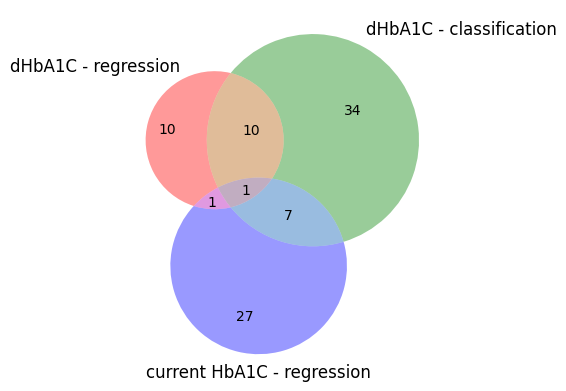

In [97]:
matplotlib_venn.venn3([set(hba1c_regression_uniprot_ids), 
                       set(hba1c_class_uniprot_ids),
                       set(current_hba1c_regression_uniprot_ids)],
                      ['dHbA1C - regression', 'dHbA1C - classification', 'current HbA1C - regression'])

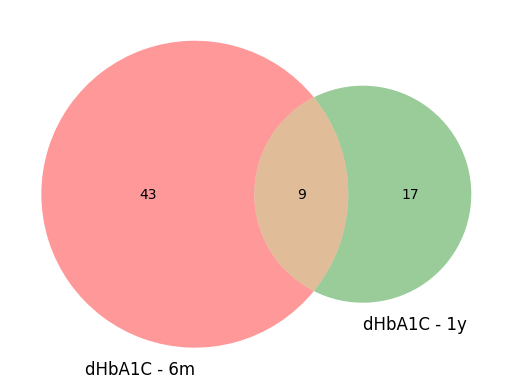

In [274]:
matplotlib_venn.venn2([set(hba1c_class_uniprot_ids),
                       set(hba1c_class_1y_uniprot_ids)],
                      ['dHbA1C - 6m', 'dHbA1C - 1y'])

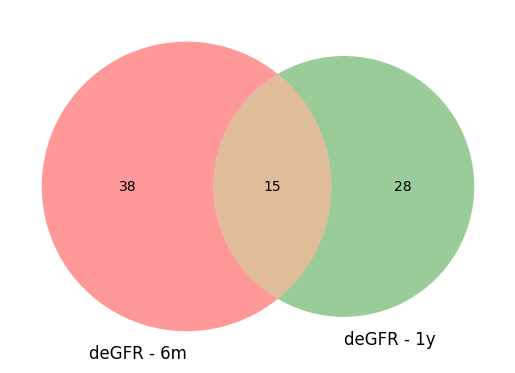

In [413]:
matplotlib_venn.venn2([set(gfr_class_uniprot_ids),
                       set(gfr_class_1y_uniprot_ids)],
                      ['deGFR - 6m', 'deGFR - 1y'])

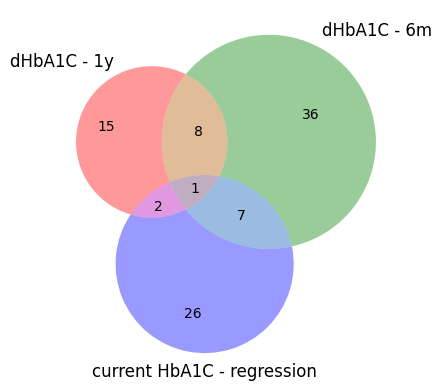

In [278]:
matplotlib_venn.venn3([set(hba1c_class_1y_uniprot_ids), 
                       set(hba1c_class_uniprot_ids),
                       set(current_hba1c_regression_uniprot_ids)],
                      ['dHbA1C - 1y', 'dHbA1C - 6m', 'current HbA1C - regression'])

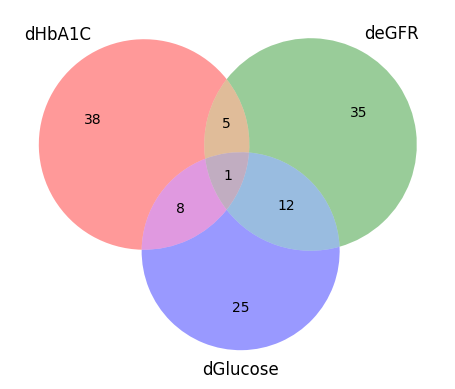

In [98]:
matplotlib_venn.venn3([set(hba1c_class_uniprot_ids), 
                       set(gfr_class_uniprot_ids),
                       set(glucose_class_uniprot_ids)],
                      ['dHbA1C', 'deGFR', 'dGlucose'])
plt.savefig('images_2023_10_18/weights_venn_diagram.png', dpi=300)

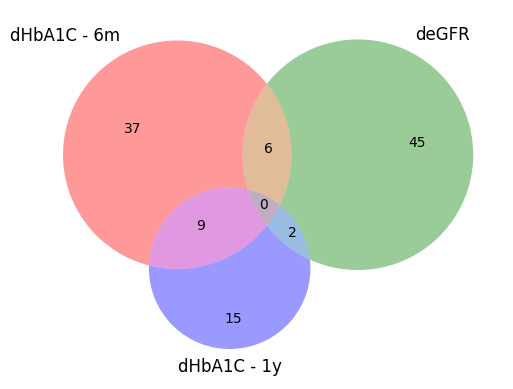

In [398]:
matplotlib_venn.venn3([set(hba1c_class_uniprot_ids), 
                       set(gfr_class_uniprot_ids),
                       set(hba1c_class_1y_uniprot_ids)],
                      ['dHbA1C - 6m', 'deGFR', 'dHbA1C - 1y'])

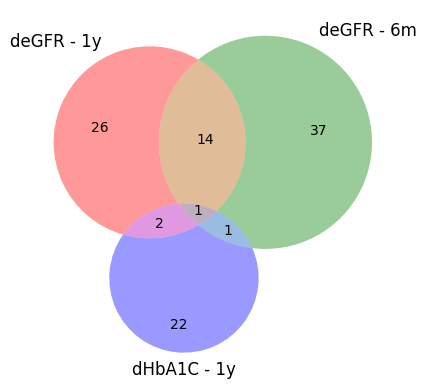

In [414]:
matplotlib_venn.venn3([set(gfr_class_1y_uniprot_ids), 
                       set(gfr_class_uniprot_ids),
                       set(hba1c_class_1y_uniprot_ids)],
                      ['deGFR - 1y', 'deGFR - 6m', 'dHbA1C - 1y'])

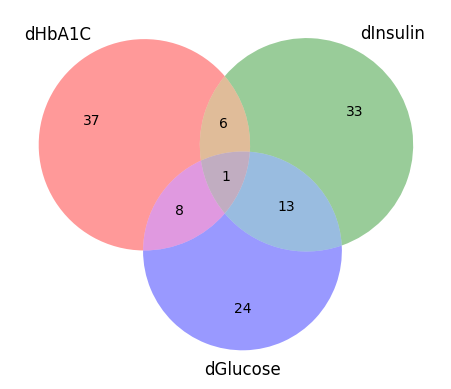

In [99]:
matplotlib_venn.venn3([set(hba1c_class_uniprot_ids), 
                       set(insulin_class_uniprot_ids),
                       set(glucose_class_uniprot_ids)],
                      ['dHbA1C', 'dInsulin', 'dGlucose'])

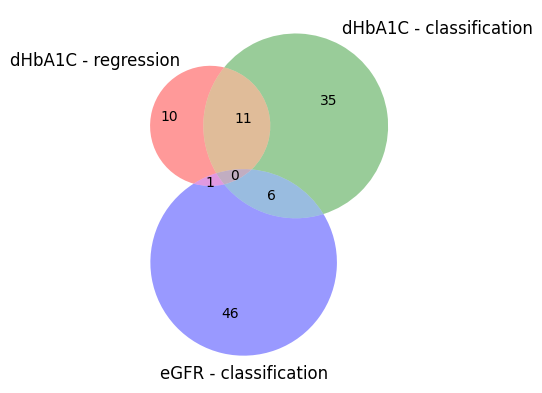

In [100]:
matplotlib_venn.venn3([set(hba1c_regression_uniprot_ids), 
                       set(hba1c_class_uniprot_ids),
                       set(gfr_class_uniprot_ids)],
                      ['dHbA1C - regression', 'dHbA1C - classification', 'eGFR - classification'])

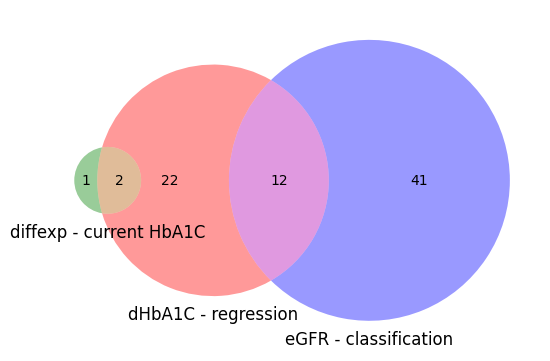

In [101]:
matplotlib_venn.venn3([set(current_hba1c_regression_uniprot_ids), 
                       set(diffexp_hba1c_uniprot),
                       set(gfr_class_uniprot_ids)],
                      ['dHbA1C - regression', 'diffexp - current HbA1C', 'eGFR - classification'])

In [ ]:
# TODO: hypergeometric tests between different protein sets?

## 3. Generate Steiner trees/subgraphs for the protein sets

In [102]:
import ipycytoscape
# TODO: display the node category somewhere, and display the edge categories
graph_style = [{'selector': 'node[feature_name]',
                             'style': {
                                  'font-family': 'helvetica',
                                  'font-size': '20px',
                                 'text-valign': 'top',
                                 'label': 'data(feature_name)',
                        }},
                        {'selector': 'node[category="Protein"]',
                         'style': {
                             'background-color': 'blue',
                         }},
                       {'selector': 'node[category="Gene"]',
                         'style': {
                             'background-color': 'yellow',
                         }},
                       {'selector': 'node[category="Disease"]',
                         'style': {
                             'background-color': 'orange',
                         }},
                       {'selector': 'node[category="Disease"]',
                         'style': {
                             'background-color': 'orange',
                         }},
                       {'selector': 'node[category="Compound"]',
                         'style': {
                             'background-color': 'purple',
                         }},
                        {'selector': 'node[in_query=1]',
                         'style': {
                             'border-width': '3px',
                             'border-color': 'red',
                         }},
                        {'selector': 'edge[type]',
                         'style': {
                             'width': '1.5px',
                         }},
                        {'selector': 'edge[type="INTERACTS_PiP"]',
                         'style': {
                             'line-color': 'cornflowerblue',
                         }},
                       {'selector': 'edge[type!="INTERACTS_PiP"]',
                         'style': {
                             'label': 'data(type)',
                         }},
                        {"selector": "edge.directed",
                         "style": {
                            "curve-style": "bezier",
                            "target-arrow-shape": "triangle",
                    }},

                    ]

### 0) all T2D drugs

In [103]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 all_t2d_drug_ids,
                                                                                 method='takahashi')

In [104]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

### a) dHbA1C regression

In [105]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 hba1c_regression_spoke_ids + [t2d_node_id] + all_t2d_drug_ids,
                                                                                 method='takahashi')

In [106]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

### b) dHbA1C classification

In [107]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 hba1c_class_spoke_ids,
                                                                                 method='takahashi')

In [108]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_st.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [109]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 hba1c_class_spoke_ids[:10] + [t2d_node_id],
                                                                                 method='takahashi')

# TODO: to figure out the disease connections, maybe we want to get the shortest paths to the node rather than getting the steiner tree?

In [110]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_st.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [111]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

#### dHbA1C classification genes

In [112]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 hba1c_class_spoke_ids + hba1c_class_gene_spoke_ids + [t2d_node_id, metformin_id],
                                                                                 method='takahashi')

In [113]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [114]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 hba1c_class_gene_spoke_ids + [t2d_node_id],
                                                                                 method='takahashi')

In [115]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [116]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 hba1c_class_top_gene_spoke_ids + [t2d_node_id],
                                                                                 method='takahashi')

In [117]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

#### bio spoke subset

### d) dGFR classification

In [118]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 gfr_class_spoke_ids,
                                                                                 method='takahashi')

In [119]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_st.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [415]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 gfr_class_top_spoke_ids + [t2d_node_id, ckd_node_id],
                                                                                 method='takahashi')

In [416]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_st.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [122]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

#### dGFR classification genes

In [123]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 gfr_class_top_gene_spoke_ids + [t2d_node_id, ckd_node_id],
                                                                                 method='takahashi')

In [124]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

## Getting shortest paths subgraphs from top ranking nodes to T2D

### dHbA1C classification

In [125]:
paths_subgraph, paths_subgraph_full = kgfe.explanations.shortest_paths_subgraph(spoke_graph_ud_connected, hba1c_class_top_spoke_ids, t2d_node_id)

In [126]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = paths_subgraph_full.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [127]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = paths_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [128]:
paths_subgraph, paths_subgraph_full = kgfe.explanations.shortest_paths_subgraph(spoke_graph_ud_connected, hba1c_class_top_gene_spoke_ids, t2d_node_id)

In [129]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = paths_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

### dGFR classification

In [130]:
paths_subgraph, paths_subgraph_full = kgfe.explanations.shortest_paths_subgraph(spoke_graph_ud_connected, gfr_class_top_spoke_ids, ckd_node_id)

In [131]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = paths_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [132]:
paths_subgraph, paths_subgraph_full = kgfe.explanations.shortest_paths_subgraph(spoke_graph_ud_connected, gfr_class_top_spoke_ids, t2d_node_id)

In [133]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = paths_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

## 4. Run topic pagerank to identify related genes/proteins/etc...

### b) dHbA1C classification LogRegLasso weights

In [134]:
hba1c_class_pr_results, hba1c_class_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud_connected, hba1c_class_spoke_ids)

In [135]:
hba1c_class_top10_pr_results, hba1c_class_top10_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud_connected, hba1c_class_top_spoke_ids)

In [136]:
hba1c_class_gene_pr_results, hba1c_class_gene_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud_connected, hba1c_class_gene_spoke_ids)

In [137]:
hba1c_class_gene_top10_pr_results, hba1c_class_gene_top10_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud_connected, hba1c_class_top_gene_spoke_ids)

#### Top 10 nodes

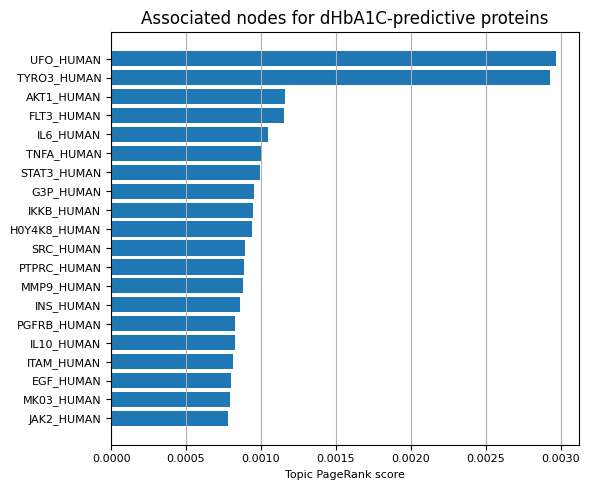

In [138]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in hba1c_class_top10_top_nodes[:20][::-1]], [x['score'] for x in hba1c_class_top10_top_nodes[:20][::-1]], )
plt.title('Associated nodes for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_1.png', dpi=300)

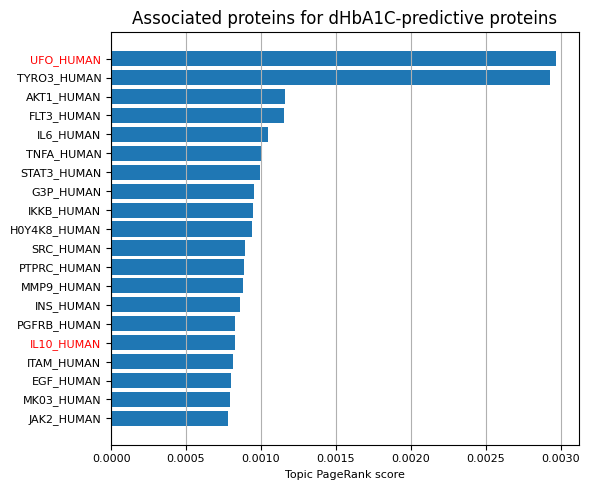

In [419]:
high_prots_top_proteins = [x for x in hba1c_class_top10_top_nodes if x['category'] == 'Protein']
prots_in_regression = [x['name'] in hba1c_class_spoke_ids for x in high_prots_top_proteins[:20]]
# proteins highlighted in red are also part of the regression model...

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
for i, in_regression in enumerate(prots_in_regression[::-1]):
    if in_regression:
        ax.get_yticklabels()[i].set_color("red")
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_proteins.png', dpi=300)

In [417]:
# TODO: steiner tree/subgraph for these proteins

In [140]:
# idea: can we highlight drugs that are known to be associated with T2D?
# 

In [421]:
high_prots_spoke_ids = [x['name'] for x in high_prots_top_proteins[:20]]

In [424]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 high_prots_spoke_ids + [t2d_node_id],
                                                                                 method='takahashi')

In [425]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

In [426]:
hba1c_outliers_st, hba1c_outliers_subgraph = kgfe.explanations.steiner_tree_subgraph(spoke_graph_ud_connected,
                                                                                 high_prots_spoke_ids,
                                                                                 method='takahashi')

In [427]:
undirected = ipycytoscape.CytoscapeWidget()
high_protein_subgraph_nx = hba1c_outliers_subgraph.to_networkx()
node_dict = {i: n['name'] for i, n in high_protein_subgraph_nx.nodes.items()}
high_protein_subgraph_nx = nx.relabel_nodes(high_protein_subgraph_nx, node_dict)
undirected.graph.add_graph_from_networkx(high_protein_subgraph_nx)
undirected.set_tooltip_source('feature_name')
undirected.set_layout(title='high_proteins', nodeSpacing=80, edgeLengthVal=50, )
undirected.set_style(graph_style)

display(undirected)

CytoscapeWidget(cytoscape_layout={'name': 'cola', 'title': 'high_proteins', 'nodeSpacing': 80, 'edgeLengthVal'…

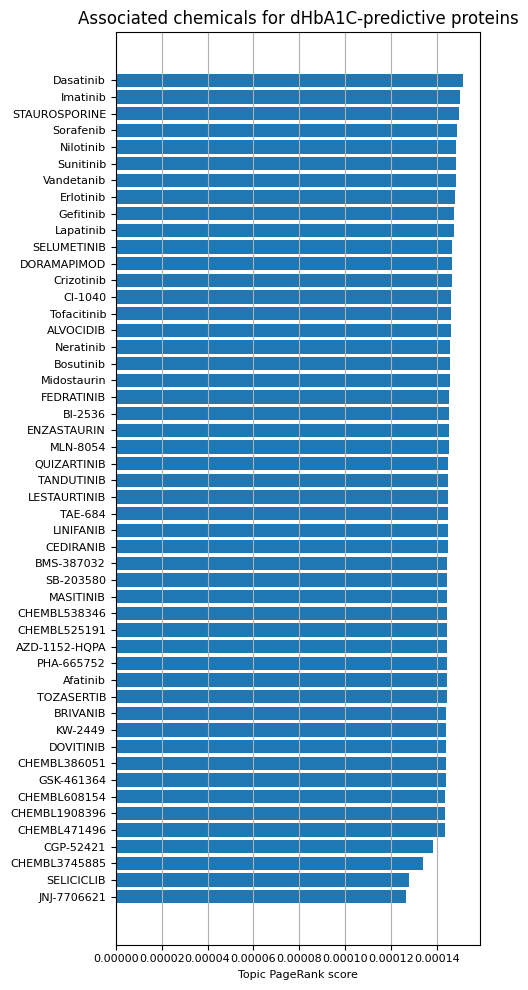

In [141]:
high_prots_top_chems = [x for x in hba1c_class_top10_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(5,10))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_chems[:50][::-1]], [x['score'] for x in high_prots_top_chems[:50][::-1]], )
plt.title('Associated chemicals for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_chems.png', dpi=300)

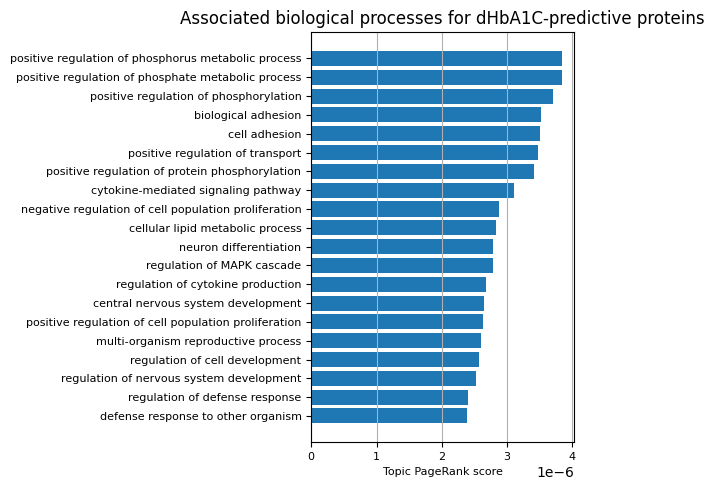

In [142]:
high_prots_top_bp = [x for x in hba1c_class_top10_top_nodes if x['category'] == 'BiologicalProcess']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_bp[:20][::-1]], [x['score'] for x in high_prots_top_bp[:20][::-1]], )
plt.title('Associated biological processes for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_bp.png', dpi=300)

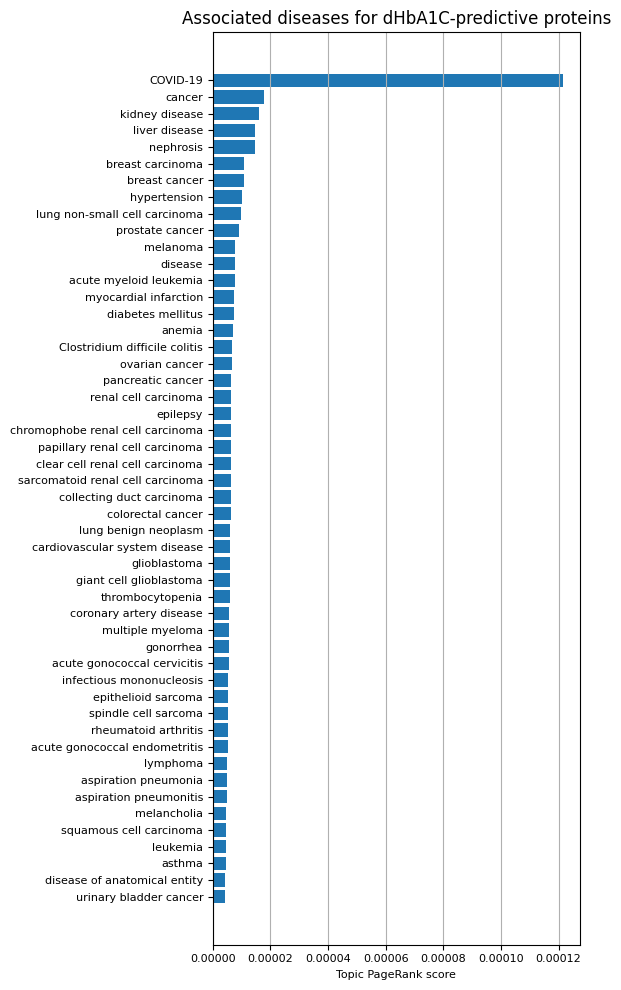

In [143]:
high_prots_top_bp = [x for x in hba1c_class_top10_top_nodes if x['category'] == 'Disease']

fig, ax = plt.subplots(figsize=(6, 10))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_bp[:50][::-1]], [x['score'] for x in high_prots_top_bp[:50][::-1]], )
plt.title('Associated diseases for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_disease.png', dpi=300)

#### All positive proteins

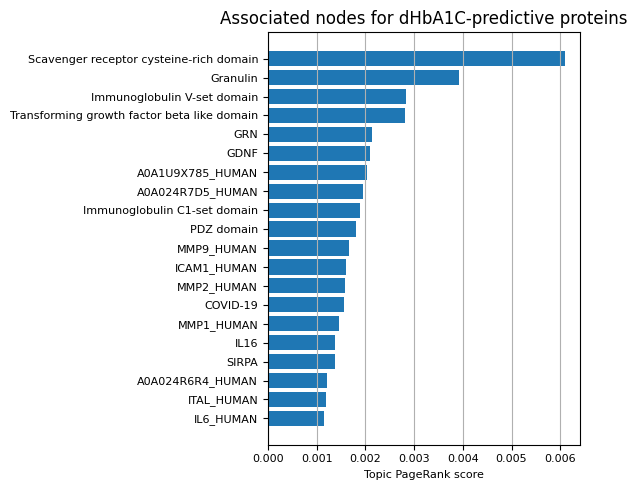

In [144]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in hba1c_class_top_nodes[:20][::-1]], [x['score'] for x in hba1c_class_top_nodes[:20][::-1]], )
plt.title('Associated nodes for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_all.png', dpi=300)

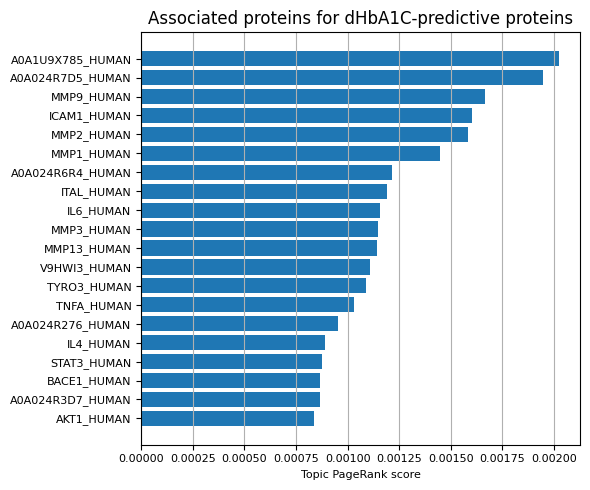

In [145]:
high_prots_top_proteins = [x for x in hba1c_class_top_nodes if x['category'] == 'Protein']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_proteins_all.png', dpi=300)

In [146]:
# idea: are the other top 10 nodes included in the broader sets?

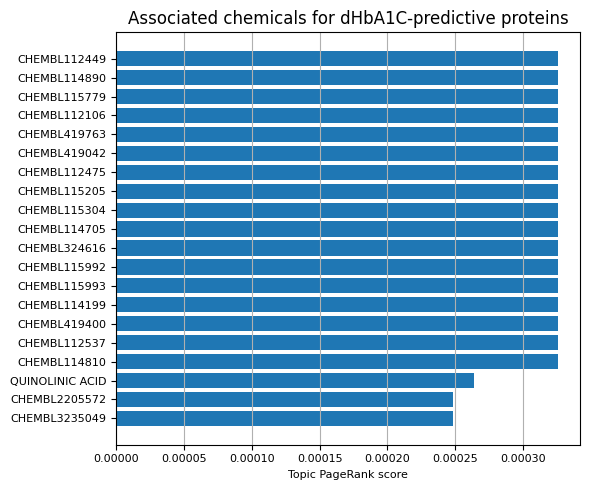

In [147]:
high_prots_top_chems = [x for x in hba1c_class_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_chems[:20][::-1]], [x['score'] for x in high_prots_top_chems[:20][::-1]], )
plt.title('Associated chemicals for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_chems_all.png', dpi=300)

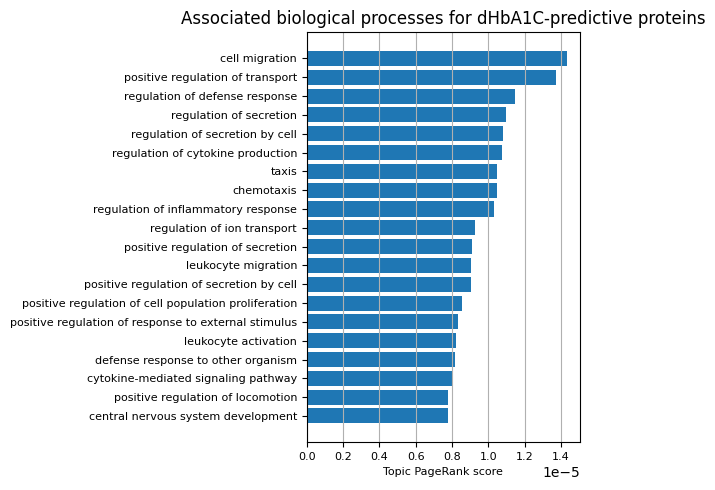

In [148]:
high_prots_top_bp = [x for x in hba1c_class_top_nodes if x['category'] == 'BiologicalProcess']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_bp[:20][::-1]], [x['score'] for x in high_prots_top_bp[:20][::-1]], )
plt.title('Associated biological processes for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_bp_all.png', dpi=300)

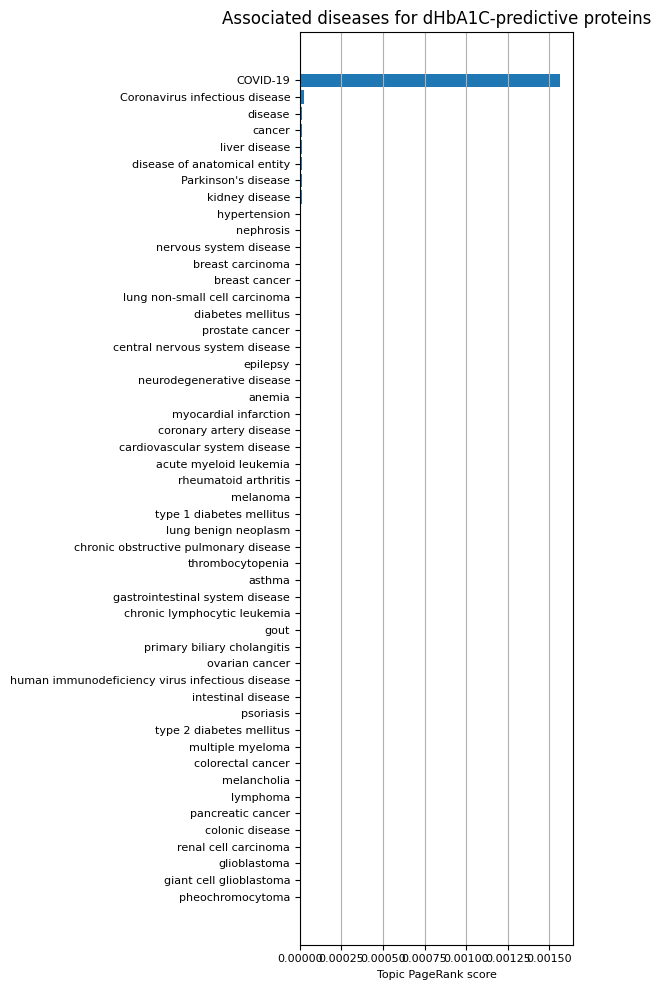

In [149]:
high_prots_top_bp = [x for x in hba1c_class_top_nodes if x['category'] == 'Disease']

fig, ax = plt.subplots(figsize=(6, 10))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_bp[:50][::-1]], [x['score'] for x in high_prots_top_bp[:50][::-1]], )
plt.title('Associated diseases for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()

#### Using all genes instead of proteins

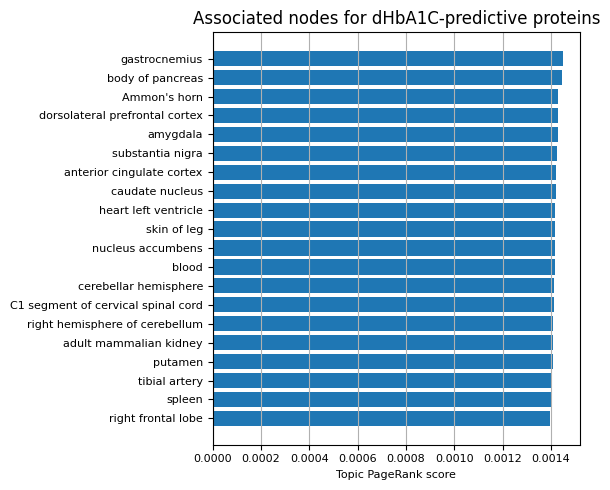

In [150]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in hba1c_class_gene_top_nodes[:20][::-1]], [x['score'] for x in hba1c_class_gene_top_nodes[:20][::-1]], )
plt.title('Associated nodes for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_genes_all.png', dpi=300)

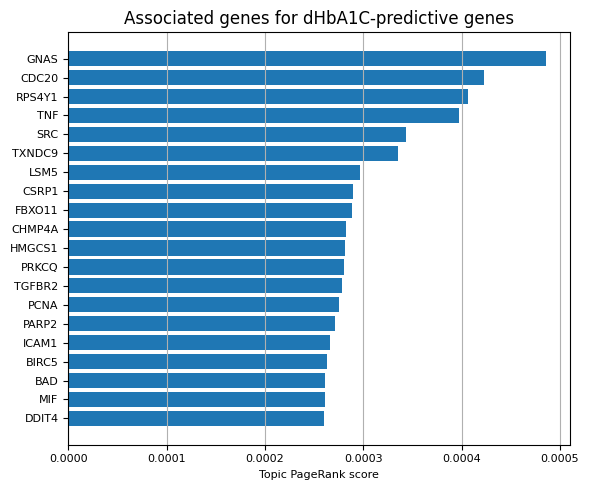

In [151]:
high_prots_top_proteins = [x for x in hba1c_class_gene_top_nodes if x['category'] == 'Gene']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated genes for dHbA1C-predictive genes')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_genes_all.png', dpi=300)

In [152]:
# idea: are the other top 10 nodes included in the broader sets?

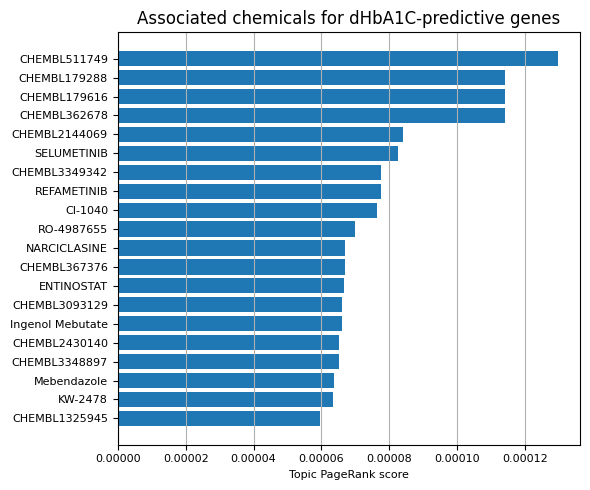

In [153]:
high_prots_top_chems = [x for x in hba1c_class_gene_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_chems[:20][::-1]], [x['score'] for x in high_prots_top_chems[:20][::-1]], )
plt.title('Associated chemicals for dHbA1C-predictive genes')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_genes_chems_all.png', dpi=300)

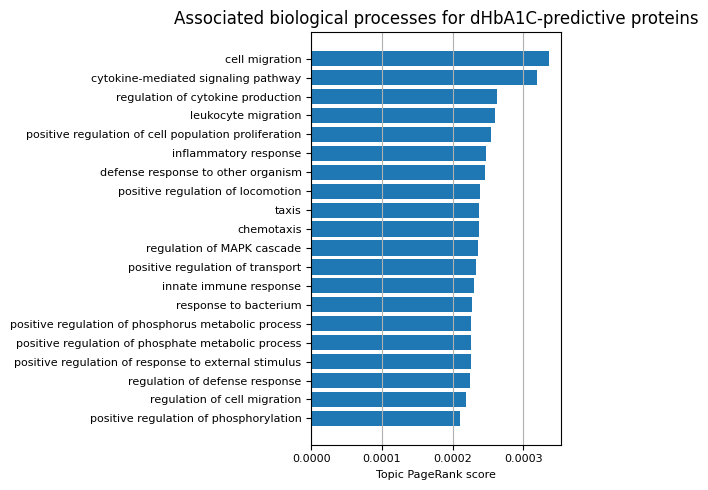

In [154]:
high_prots_top_bp = [x for x in hba1c_class_gene_top_nodes if x['category'] == 'BiologicalProcess']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_bp[:20][::-1]], [x['score'] for x in high_prots_top_bp[:20][::-1]], )
plt.title('Associated biological processes for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_genes_bp_all.png', dpi=300)

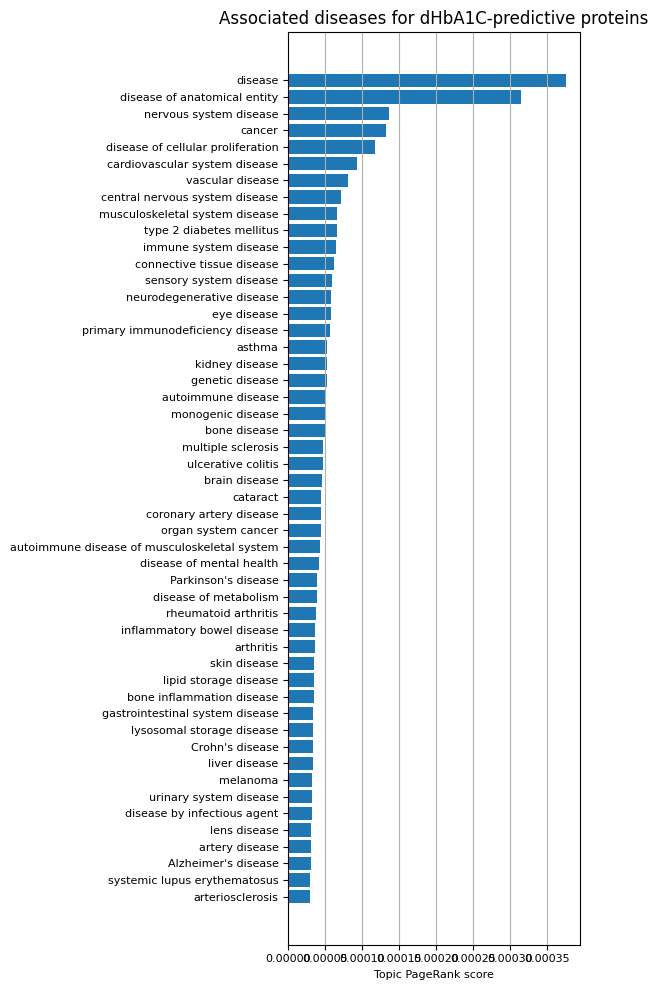

In [155]:
high_prots_top_bp = [x for x in hba1c_class_gene_top_nodes if x['category'] == 'Disease']

fig, ax = plt.subplots(figsize=(6, 10))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_bp[:50][::-1]], [x['score'] for x in high_prots_top_bp[:50][::-1]], )
plt.title('Associated diseases for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()

#### Using top 10 genes

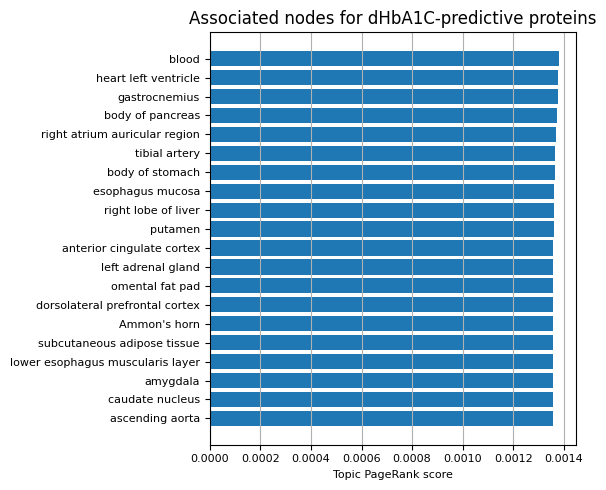

In [156]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in hba1c_class_gene_top10_top_nodes[:20][::-1]], [x['score'] for x in hba1c_class_gene_top10_top_nodes[:20][::-1]], )
plt.title('Associated nodes for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_top10genes_all.png', dpi=300)

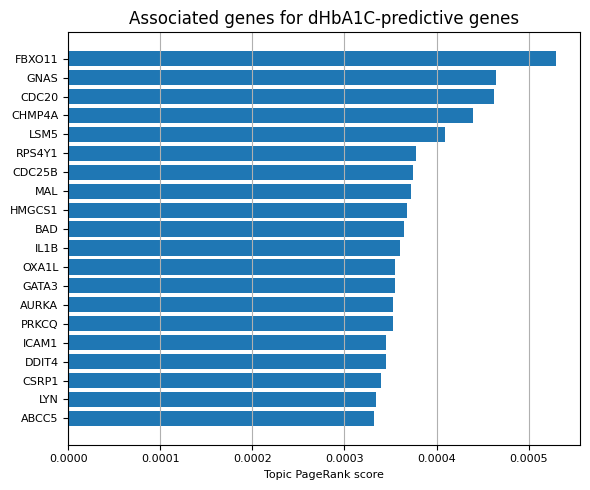

In [157]:
high_prots_top_proteins = [x for x in hba1c_class_gene_top10_top_nodes if x['category'] == 'Gene']
prots_in_regression = [x['name'] in hba1c_class_gene_spoke_ids for x in high_prots_top_proteins[:20]]


fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated genes for dHbA1C-predictive genes')
ax.set_xlabel('Topic PageRank score', fontsize=8)
for i, in_regression in enumerate(prots_in_regression[::-1]):
    if in_regression:
        ax.get_yticklabels()[i].set_color("red")
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_top10genes_genes.png', dpi=300)

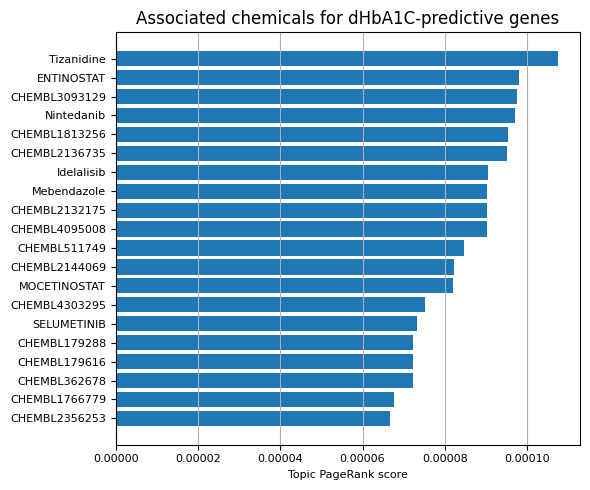

In [158]:
high_prots_top_chems = [x for x in hba1c_class_gene_top10_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_chems[:20][::-1]], [x['score'] for x in high_prots_top_chems[:20][::-1]], )
plt.title('Associated chemicals for dHbA1C-predictive genes')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_top10genes_chems.png', dpi=300)

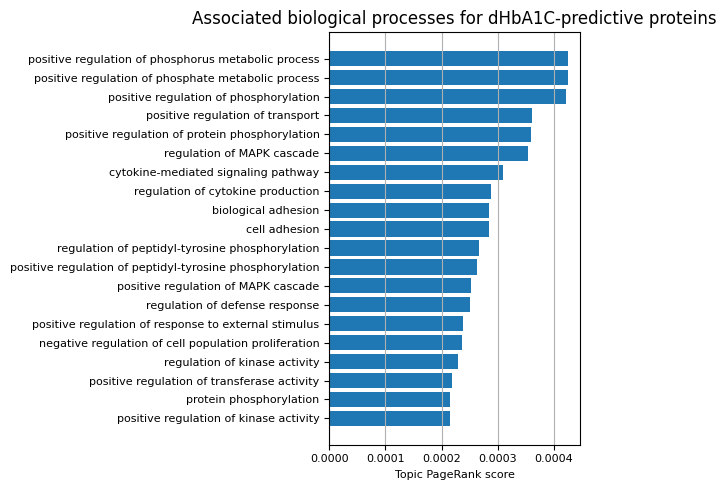

In [159]:
high_prots_top_bp = [x for x in hba1c_class_gene_top10_top_nodes if x['category'] == 'BiologicalProcess']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_bp[:20][::-1]], [x['score'] for x in high_prots_top_bp[:20][::-1]], )
plt.title('Associated biological processes for dHbA1C-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dhba1c_top10genes_bp.png', dpi=300)

### d) dGFR classification LogRegLasso weights

In [160]:
gfr_class_pr_results, gfr_class_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud_connected, gfr_class_spoke_ids)

In [161]:
gfr_class_top10_pr_results, gfr_class_top10_top_nodes = kgfe.explanations.topic_pagerank(spoke_graph_ud_connected, gfr_class_top_spoke_ids)

#### All positive proteins

#### Top 10 proteins

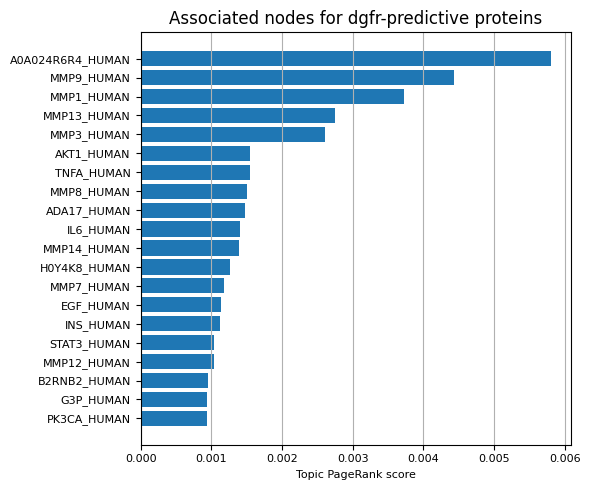

In [162]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in gfr_class_top10_top_nodes[:20][::-1]], [x['score'] for x in gfr_class_top10_top_nodes[:20][::-1]], )
plt.title('Associated nodes for dgfr-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dgfr_1.png', dpi=300)

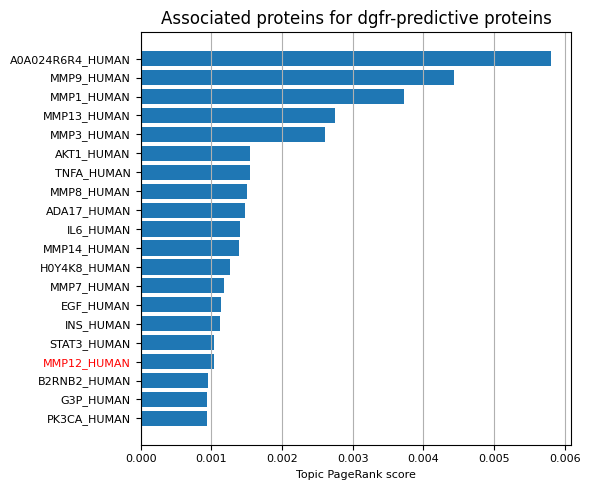

In [163]:
high_prots_top_proteins = [x for x in gfr_class_top10_top_nodes if x['category'] == 'Protein']
prots_in_regression = [x['name'] in gfr_class_spoke_ids for x in high_prots_top_proteins[:20]]


fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated proteins for dgfr-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
for i, in_regression in enumerate(prots_in_regression[::-1]):
    if in_regression:
        ax.get_yticklabels()[i].set_color("red")
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dgfr_proteins.png', dpi=300)

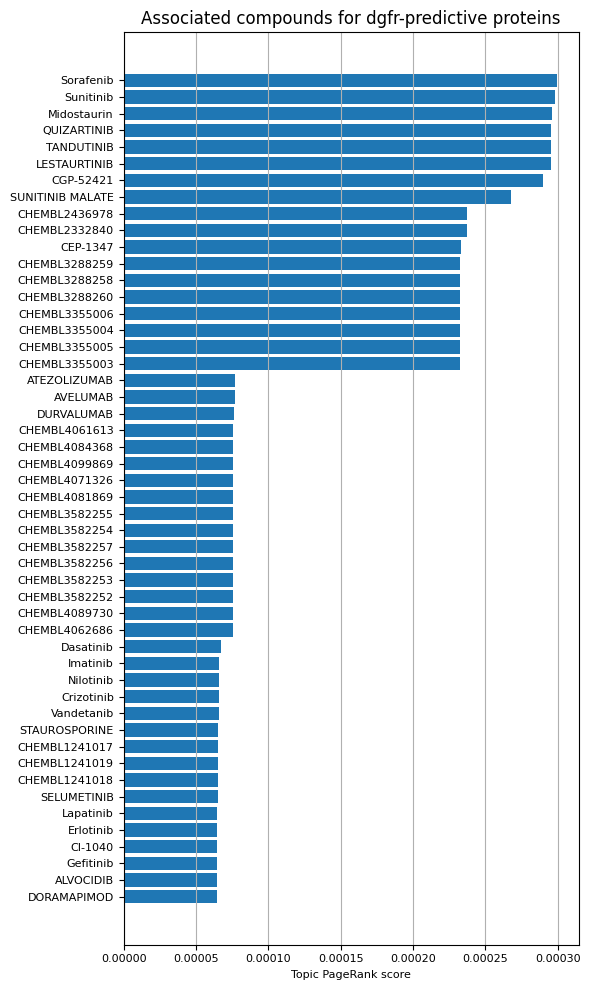

In [164]:
high_prots_top_proteins = [x for x in gfr_class_top10_top_nodes if x['category'] == 'Compound']

fig, ax = plt.subplots(figsize=(6, 10))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:50][::-1]], [x['score'] for x in high_prots_top_proteins[:50][::-1]], )
plt.title('Associated compounds for dgfr-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dgfr_compounds.png', dpi=300)

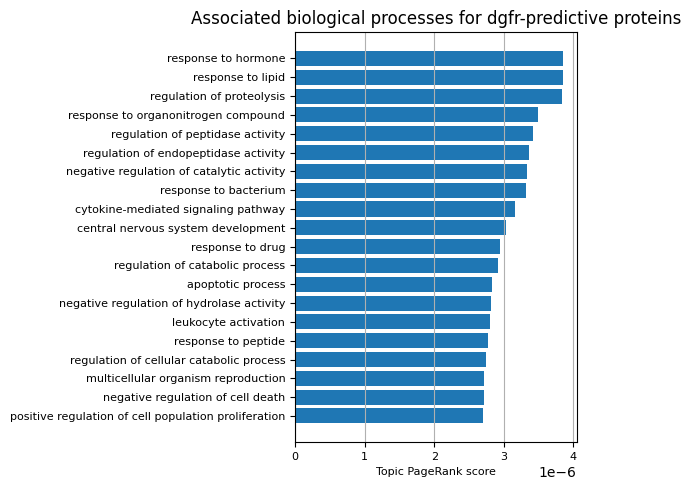

In [165]:
high_prots_top_proteins = [x for x in gfr_class_top10_top_nodes if x['category'] == 'BiologicalProcess']

fig, ax = plt.subplots(figsize=(6, 5))
ax.tick_params(axis='both', which='major', labelsize=8)
ax.barh([x['feature_name'] for x in high_prots_top_proteins[:20][::-1]], [x['score'] for x in high_prots_top_proteins[:20][::-1]], )
plt.title('Associated biological processes for dgfr-predictive proteins')
ax.set_xlabel('Topic PageRank score', fontsize=8)
ax.grid(axis='x')
plt.tight_layout()
plt.savefig('images_2023_10_18/topic_pagerank_dgfr_bp.png', dpi=300)

## 4.5. Gene set enrichment analysis for top features

It is *possible* but not certain that using graph-based analysis methods will do better than using GSEA/enrichr.

In [166]:
import gseapy

### b) dHbA1C classification

#### All genes

In [167]:
dhba1c_genes_enrichr = gseapy.enrichr(hba1c_class_positive_gene_symbols, 
               gene_sets=['KEGG_2019_Human', 'Reactome_2022', 'GO_Biological_Process_2021'])

In [168]:
dhba1c_genes_enrichr.results[(dhba1c_genes_enrichr.results['Adjusted P-value'] < 0.01)].sort_values('Adjusted P-value').head(20)

Gene_set  \
0               KEGG_2019_Human   
450  GO_Biological_Process_2021   
451  GO_Biological_Process_2021   
124               Reactome_2022   
125               Reactome_2022   
452  GO_Biological_Process_2021   
126               Reactome_2022   
453  GO_Biological_Process_2021   
454  GO_Biological_Process_2021   
455  GO_Biological_Process_2021   
456  GO_Biological_Process_2021   
457  GO_Biological_Process_2021   
458  GO_Biological_Process_2021   
459  GO_Biological_Process_2021   
460  GO_Biological_Process_2021   
127               Reactome_2022   
1               KEGG_2019_Human   
461  GO_Biological_Process_2021   
462  GO_Biological_Process_2021   
128               Reactome_2022   

                                                  Term  Overlap       P-value  \
0               Cytokine-cytokine receptor interaction   16/294  2.034005e-17   
450   cytokine-mediated signaling pathway (GO:0019221)   20/621  2.554511e-17   
451  cellular response to cytokine stimulus (GO:007...   18/482  1.100435e-16   
124                         Immune System R-HSA-168256  28/1943  1.547644e-15   
125             Signaling By Interleukins R-HSA-449147   16/453  1.809776e-14   
452                 inflammatory response (GO:0006954)   13/230  1.869447e-14   
126  Cytokine Signaling In Immune System R-HSA-1280215   17/702  1.071102e-12   
453                  neutrophil migration (GO:1990266)     8/77  2.181010e-11   
454             response to interleukin-1 (GO:0070555)     8/86  5.403598e-11   
455   regulation of inflammatory response (GO:0050727)   10/206  1.171848e-10   
456    cellular response to interleukin-1 (GO:0071347)    9/155  2.209394e-10   
457                 neutrophil chemotaxis (GO:0030593)     7/70  5.581691e-10   
458                granulocyte chemotaxis (GO:0071621)     7/73  7.541787e-10   
459  cellular response to lipopolysaccharide (GO:00...    8/120  8.005376e-10   
460                   monocyte chemotaxis (GO:0002548)     6/42  1.119652e-09   
127             Interleukin-10 Signaling R-HSA-6783783     6/45  1.728217e-09   
1               Fluid shear stress and atherosclerosis    8/139  2.583903e-09   
461  chemokine-mediated signaling pathway (GO:0070098)     6/56  6.741325e-09   
462        response to lipopolysaccharide (GO:0032496)    8/159  7.476122e-09   
128  Interleukin-4 And Interleukin-13 Signaling R-H...    7/107  1.128712e-08   

     Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0        2.522166e-15            0                     0   31.446843   
450      2.930025e-14            0                     0   20.119592   
451      6.310997e-14            0                     0   22.230730   
124      5.045320e-13            0                     0   10.986162   
125      2.949935e-12            0                     0   19.843377   
452      7.147518e-12            0                     0   30.308756   
126      1.163930e-10            0                     0   13.658853   
453      6.254048e-09            0                     0   52.382082   
454      1.239585e-08            0                     0   46.317016   
455      2.240183e-08            0                     0   23.994169   
456      3.620249e-08            0                     0   28.387703   
457      8.002749e-08            0                     0   49.098765   
458      9.182167e-08            0                     0   46.859933   
459      9.182167e-08            0                     0   32.201299   
460      1.167492e-07            0                     0   72.144928   
127      1.408497e-07            0                     0   66.585284   
1        1.602020e-07            0                     0   27.504511   
461      6.443584e-07            0                     0   51.907826   
462      6.596240e-07            0                     0   23.837447   
128      7.359200e-07            0                     0   30.874667   

     Combined Score                                              Genes  

In [169]:
dhba1c_genes_enrichr.results[dhba1c_genes_enrichr.results.Term.str.contains('diabetes')]

Gene_set                      Term Overlap   P-value  \
33  KEGG_2019_Human  Type I diabetes mellitus    2/43  0.005593   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
33          0.020397            0                     0   19.421463   

    Combined Score       Genes  
33      100.725689  IL1A;IL12B

#### Top 10 genes

In [170]:
dhba1c_top_10_genes_enrichr = gseapy.enrichr(hba1c_class_top_gene_symbols,
                                            gene_sets=['KEGG_2019_Human', 'Reactome_2022', 'GO_Biological_Process_2021'])

Exception: Error sending gene list, try again later

In [ ]:
dhba1c_top_10_genes_enrichr.results

In [ ]:
dhba1c_top_10_genes_enrichr.results[(dhba1c_top_10_genes_enrichr.results['Adjusted P-value'] < 0.01)].sort_values('Adjusted P-value').head(20)

In [ ]:
dhba1c_top_10_genes_enrichr.results[dhba1c_top_10_genes_enrichr.results.Term.str.contains('diabetes')]

## 5. Graph null model to assess node set coherence / cliqueishness

In [171]:
import matplotlib.pyplot as plt

In [172]:
all_prots_spoke_ids = [uniprot_to_ids[x] for x in prot_names.loc[prot_regression_weights.columns[:-5]]['uniprot'] if x in uniprot_to_ids]

In [173]:
len(all_prots_spoke_ids)

259

In [174]:
all_genes_spoke_ids = [genes_to_ids[x] for x in \
                       gene_names.get_ids(prot_names.loc[prot_regression_weights.columns[:-5]]['gene_name']) \
                       if x in uniprot_to_ids]

In [175]:
# TODO: instead of using Arivale proteins as the null distribution, use a weighted random sample from all SPOKE-human proteins.

### a) dHbA1C regression

In [176]:
hba1c_regression_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(hba1c_regression_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [192]:
hba1c_regression_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                               len(hba1c_regression_spoke_ids),
                                                                input_id_set=hba1c_regression_spoke_ids,
                                                                   use_degree_sampling=True,
                                                                               #ids_subset=all_prots_spoke_ids,
                                                                               target_nodes=[t2d_node_id])

In [193]:
hba1c_regression_null_results = pd.DataFrame(hba1c_regression_null_results)

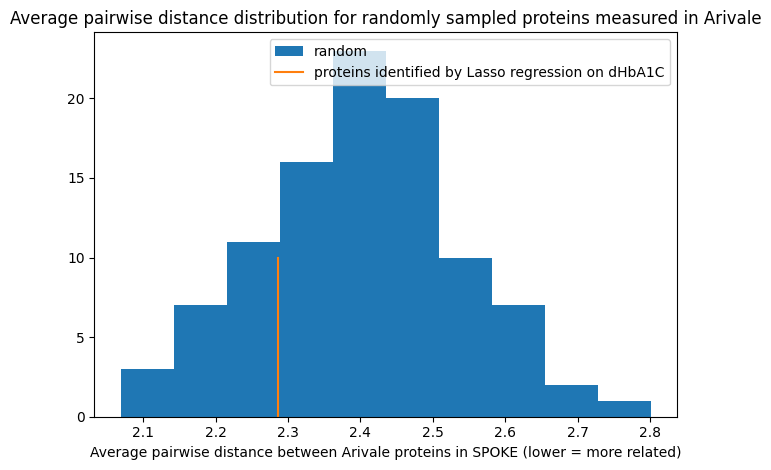

In [194]:
plt.hist(hba1c_regression_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([hba1c_regression_stats['average_pairwise_distance'], hba1c_regression_stats['average_pairwise_distance']],
         [0, 10], label='proteins identified by Lasso regression on dHbA1C')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()
plt.tight_layout()
plt.savefig('images_2023_10_18/null_hba1c_regression.png', dpi=300)

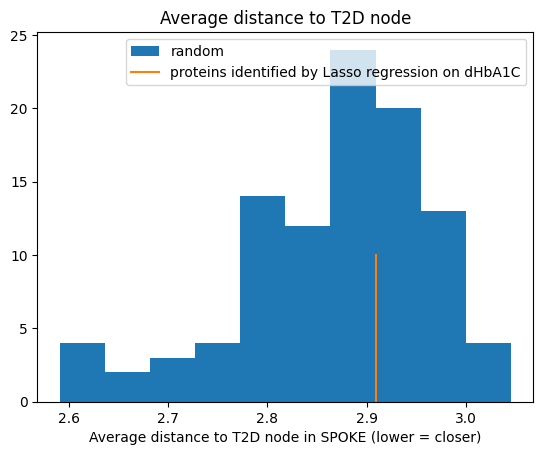

In [195]:
plt.hist(hba1c_regression_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_regression_stats['average_target_distance'], hba1c_regression_stats['average_target_distance']],
         [0, 10], label='proteins identified by Lasso regression on dHbA1C')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

### b) dHbA1C classification

In [181]:
hba1c_class_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(hba1c_class_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [183]:
hba1c_class_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                               len(hba1c_class_spoke_ids),
                                                              input_id_set=hba1c_class_spoke_ids,
                                                              use_degree_sampling=True,
                                                                               #ids_subset=all_prots_spoke_ids,
                                                                               target_nodes=[t2d_node_id])

In [184]:
hba1c_class_null_results = pd.DataFrame(hba1c_class_null_results)

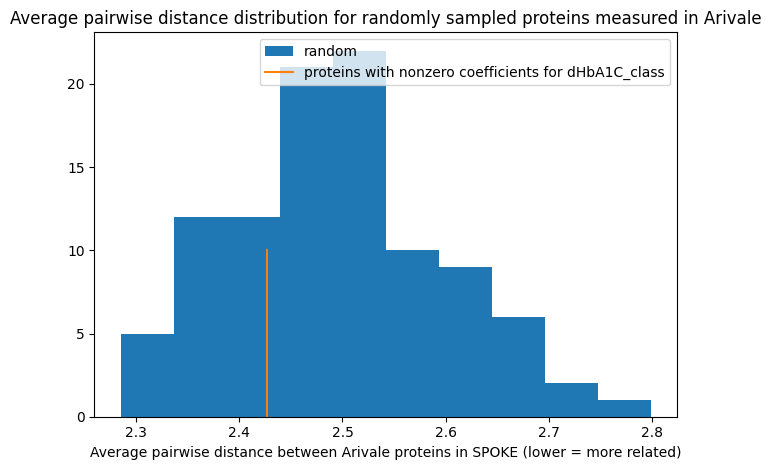

In [185]:
plt.hist(hba1c_class_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([hba1c_class_stats['average_pairwise_distance'], hba1c_class_stats['average_pairwise_distance']],
         [0, 10], label='proteins with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()
plt.tight_layout()
plt.savefig('images_2023_10_18/null_hba1c_classification.png', dpi=300)

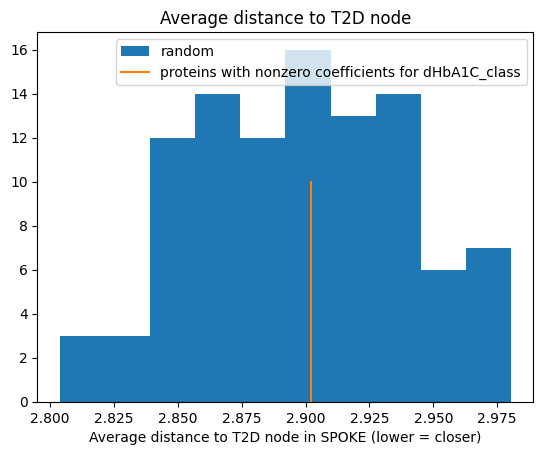

In [186]:
plt.hist(hba1c_class_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_class_stats['average_target_distance'], hba1c_class_stats['average_target_distance']],
         [0, 10], label='proteins with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

#### dHbA1c_class top 10

In [187]:
hba1c_class_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(hba1c_class_top_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [188]:
hba1c_class_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                               len(hba1c_class_top_spoke_ids),
                                                              input_id_set=hba1c_class_top_spoke_ids,
                                                              use_degree_sampling=True,
                                                                               #ids_subset=all_prots_spoke_ids,
                                                                               target_nodes=[t2d_node_id])

In [189]:
hba1c_class_null_results = pd.DataFrame(hba1c_class_null_results)

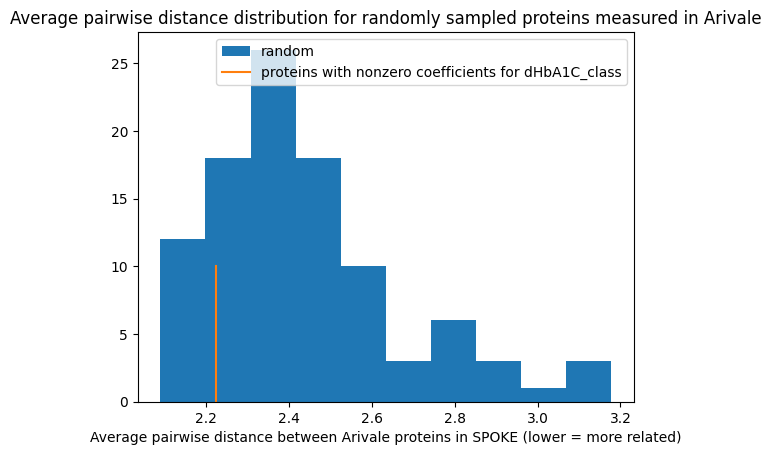

In [190]:
plt.hist(hba1c_class_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([hba1c_class_stats['average_pairwise_distance'], hba1c_class_stats['average_pairwise_distance']],
         [0, 10], label='proteins with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()

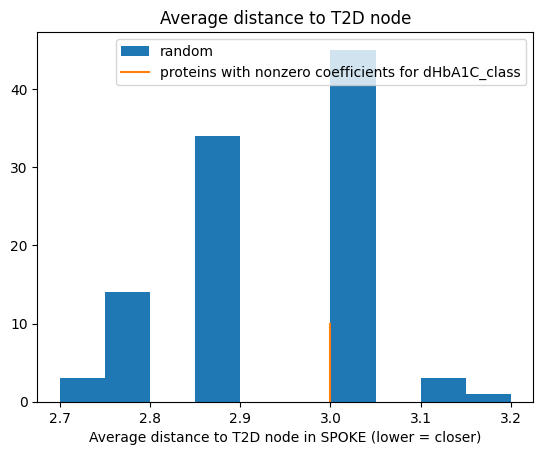

In [191]:
plt.hist(hba1c_class_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_class_stats['average_target_distance'], hba1c_class_stats['average_target_distance']],
         [0, 10], label='proteins with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

#### dHbA1C all genes

In [196]:
hba1c_class_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(hba1c_class_gene_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [197]:
hba1c_class_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Gene',
                                                                               len(hba1c_class_gene_spoke_ids),
                                                              input_id_set=hba1c_class_gene_spoke_ids,
                                                              use_degree_sampling=True,
                                                                               target_nodes=[t2d_node_id])

In [198]:
hba1c_class_null_results = pd.DataFrame(hba1c_class_null_results)

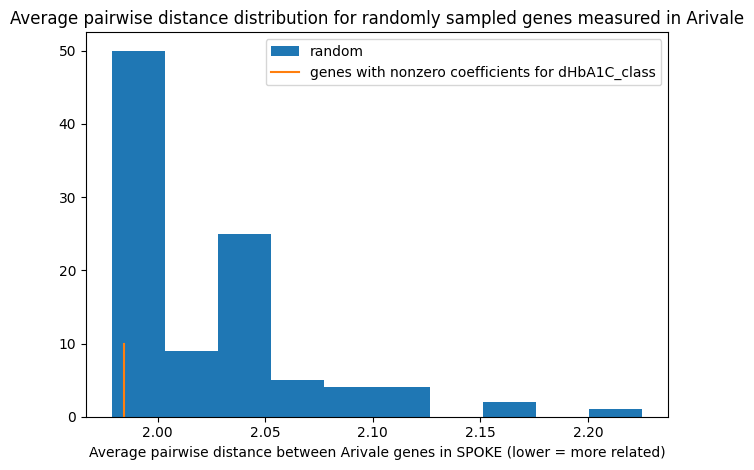

In [199]:
plt.hist(hba1c_class_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled genes measured in Arivale')
plt.plot([hba1c_class_stats['average_pairwise_distance'], hba1c_class_stats['average_pairwise_distance']],
         [0, 10], label='genes with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average pairwise distance between Arivale genes in SPOKE (lower = more related)')
plt.legend()
plt.tight_layout()
plt.savefig('images_2023_10_18/null_hba1c_classification_genes.png', dpi=300)

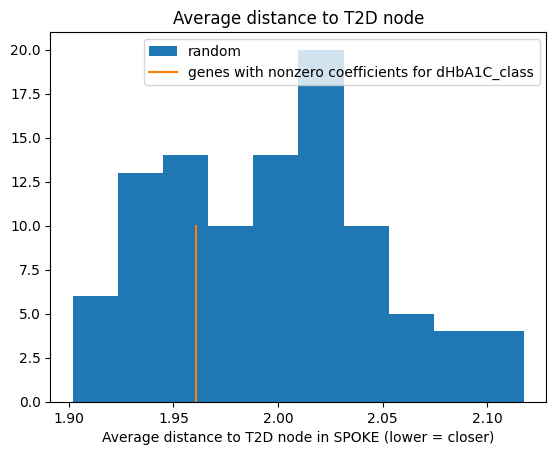

In [200]:
plt.hist(hba1c_class_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_class_stats['average_target_distance'], hba1c_class_stats['average_target_distance']],
         [0, 10], label='genes with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

#### dHbA1C top 10 genes

In [201]:
hba1c_class_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(hba1c_class_top_gene_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [202]:
hba1c_class_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                               len(hba1c_class_top_gene_spoke_ids),
                                                              input_id_set=hba1c_class_top_gene_spoke_ids,
                                                              use_degree_sampling=True,
                                                                               #ids_subset=all_prots_spoke_ids,
                                                                               target_nodes=[t2d_node_id])

In [203]:
hba1c_class_null_results = pd.DataFrame(hba1c_class_null_results)

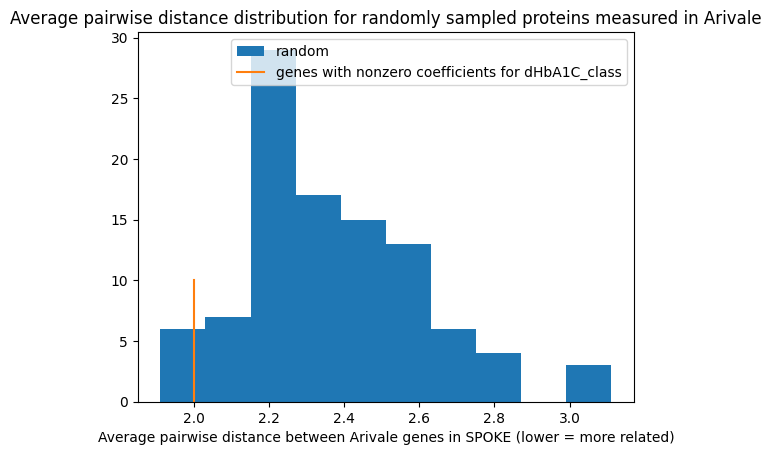

In [204]:
plt.hist(hba1c_class_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([hba1c_class_stats['average_pairwise_distance'], hba1c_class_stats['average_pairwise_distance']],
         [0, 10], label='genes with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average pairwise distance between Arivale genes in SPOKE (lower = more related)')
plt.legend()

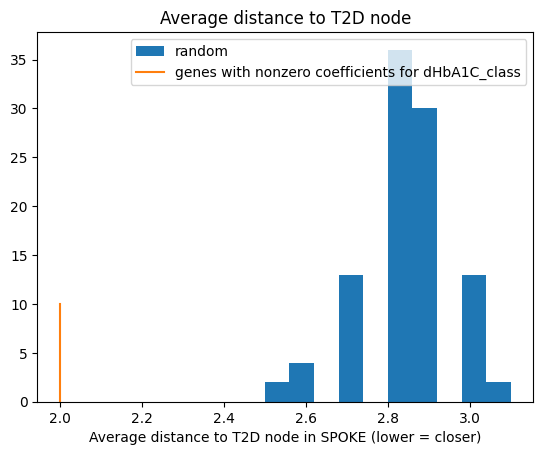

In [205]:
plt.hist(hba1c_class_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_class_stats['average_target_distance'], hba1c_class_stats['average_target_distance']],
         [0, 10], label='genes with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

### c) current-HbA1C regression

In [206]:
hba1c_current_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(current_hba1c_regression_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [207]:
hba1c_current_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                               len(current_hba1c_regression_spoke_ids),
                                                                input_id_set=current_hba1c_regression_spoke_ids,
                                                                use_degree_sampling=True,
                                                                               #ids_subset=all_prots_spoke_ids,
                                                                               target_nodes=[t2d_node_id])

In [208]:
hba1c_current_null_results = pd.DataFrame(hba1c_current_null_results)

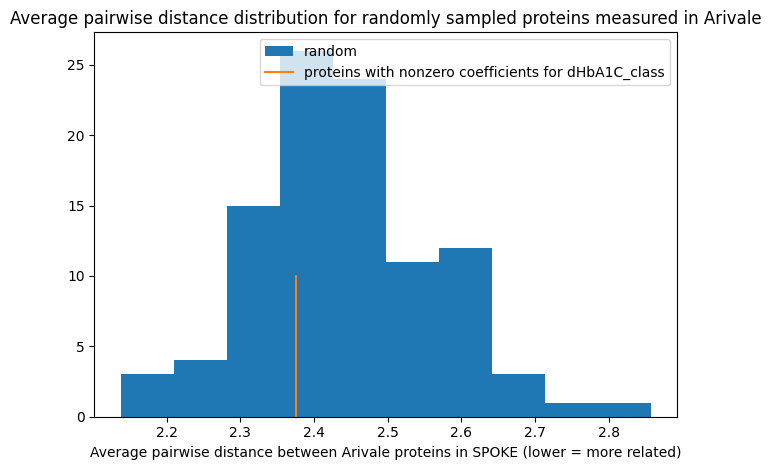

In [209]:
plt.hist(hba1c_current_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([hba1c_current_stats['average_pairwise_distance'], hba1c_current_stats['average_pairwise_distance']],
         [0, 10], label='proteins with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()
plt.tight_layout()
plt.savefig('images_2023_10_18/current_hba1c_regression.png', dpi=300)

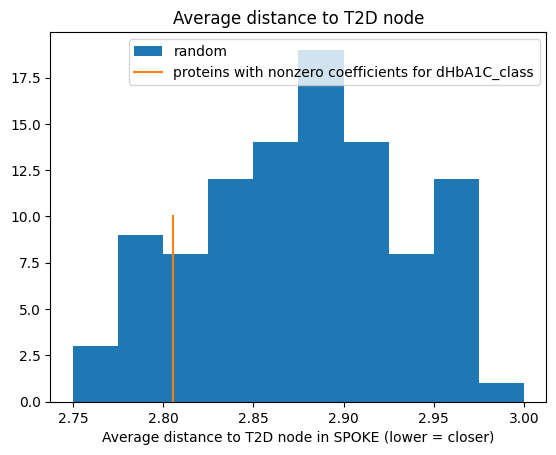

In [210]:
plt.hist(hba1c_current_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_current_stats['average_target_distance'], hba1c_current_stats['average_target_distance']],
         [0, 10], label='proteins with nonzero coefficients for dHbA1C_class')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

### e) HbA1C diffexp

In [211]:
hba1c_diffexp_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(diffexp_hba1c_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [212]:
hba1c_diffexp_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                               len(diffexp_hba1c_spoke_ids),
                                                                input_id_set=diffexp_hba1c_spoke_ids,
                                                                use_degree_sampling=True,
                                                                               #ids_subset=all_prots_spoke_ids,
                                                                               target_nodes=[t2d_node_id])

In [213]:
hba1c_diffexp_null_results = pd.DataFrame(hba1c_diffexp_null_results)

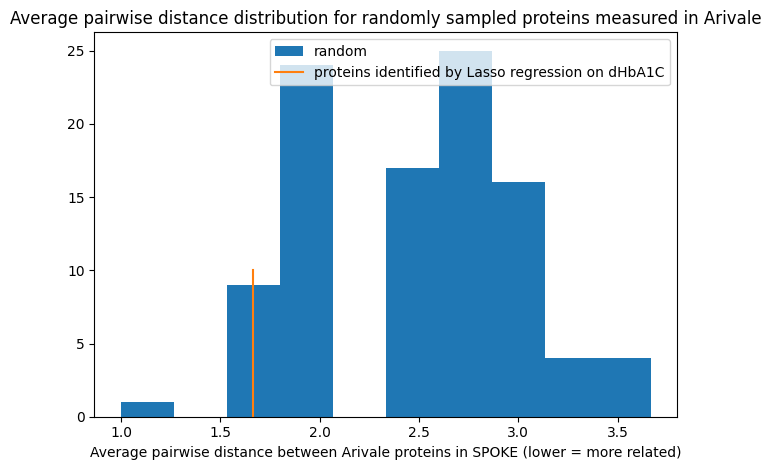

In [214]:
plt.hist(hba1c_diffexp_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([hba1c_diffexp_stats['average_pairwise_distance'], hba1c_diffexp_stats['average_pairwise_distance']],
         [0, 10], label='proteins identified by Lasso regression on dHbA1C')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()
plt.tight_layout()
plt.savefig('images_2023_10_18/hba1c_diffexp.png', dpi=300)

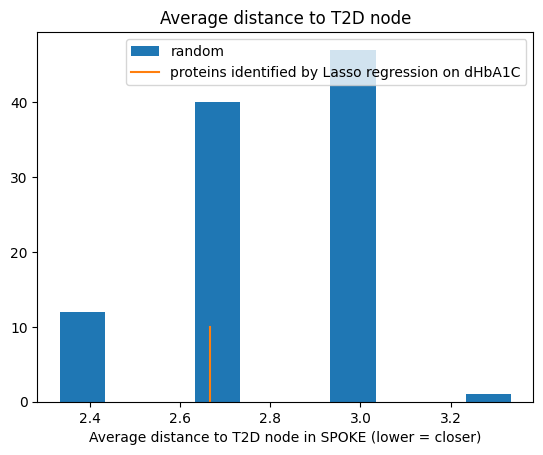

In [215]:
plt.hist(hba1c_diffexp_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([hba1c_diffexp_stats['average_target_distance'], hba1c_diffexp_stats['average_target_distance']],
         [0, 10], label='proteins identified by Lasso regression on dHbA1C')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

### d) dGFR classification

In [216]:
gfr_class_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(gfr_class_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [217]:
gfr_class_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                               len(gfr_class_spoke_ids),
                                                            input_id_set=gfr_class_spoke_ids,
                                                            use_degree_sampling=True,
                                                                               #ids_subset=all_prots_spoke_ids,
                                                                               target_nodes=[t2d_node_id])

In [218]:
gfr_class_null_results = pd.DataFrame(gfr_class_null_results)

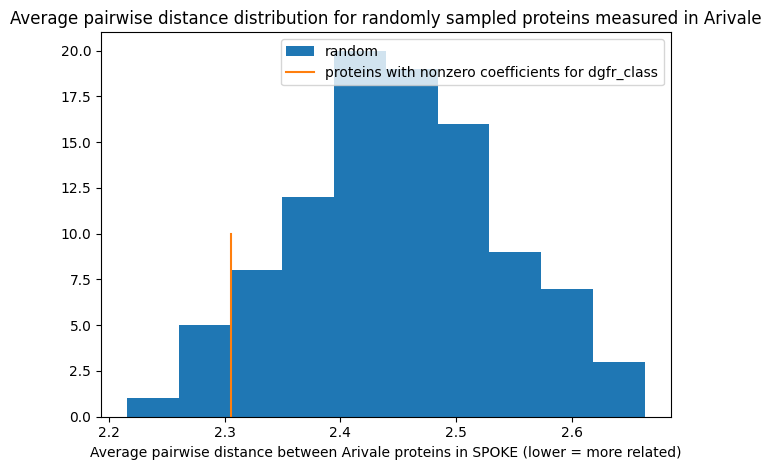

In [219]:
plt.hist(gfr_class_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([gfr_class_stats['average_pairwise_distance'], gfr_class_stats['average_pairwise_distance']],
         [0, 10], label='proteins with nonzero coefficients for dgfr_class')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()
plt.tight_layout()
plt.savefig('images_2023_10_18/null_gfr_classification.png', dpi=300)

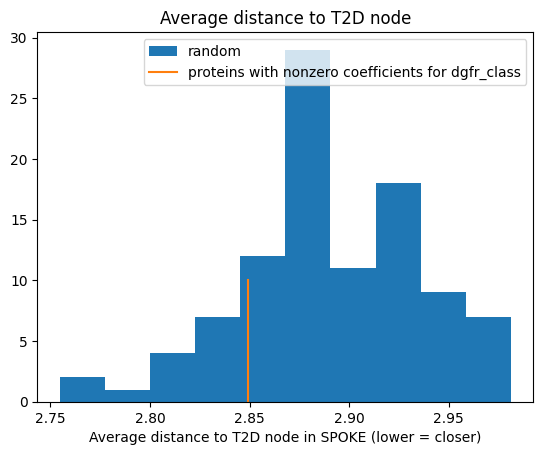

In [220]:
plt.hist(gfr_class_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([gfr_class_stats['average_target_distance'], gfr_class_stats['average_target_distance']],
         [0, 10], label='proteins with nonzero coefficients for dgfr_class')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

#### dgfr_class top 10

In [221]:
gfr_class_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(gfr_class_top_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [222]:
gfr_class_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Protein',
                                                                               len(gfr_class_top_spoke_ids),
                                                            input_id_set=gfr_class_top_spoke_ids,
                                                            use_degree_sampling=True,
                                                                               #ids_subset=all_prots_spoke_ids,
                                                                               target_nodes=[t2d_node_id])

In [223]:
gfr_class_null_results = pd.DataFrame(gfr_class_null_results)

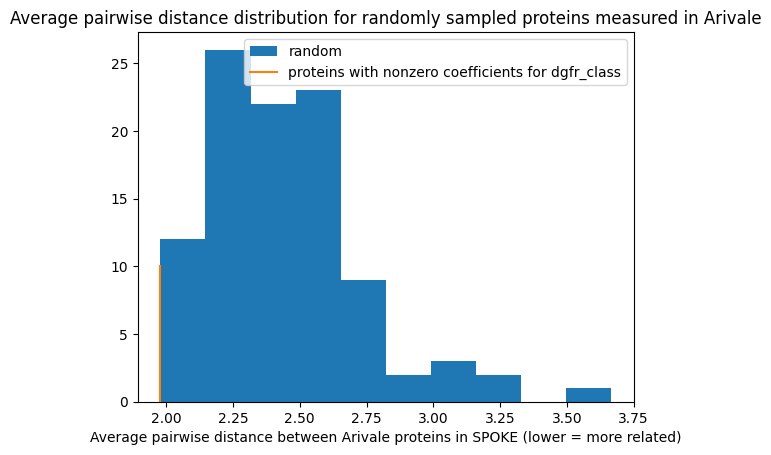

In [224]:
plt.hist(gfr_class_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([gfr_class_stats['average_pairwise_distance'], gfr_class_stats['average_pairwise_distance']],
         [0, 10], label='proteins with nonzero coefficients for dgfr_class')
plt.xlabel('Average pairwise distance between Arivale proteins in SPOKE (lower = more related)')
plt.legend()

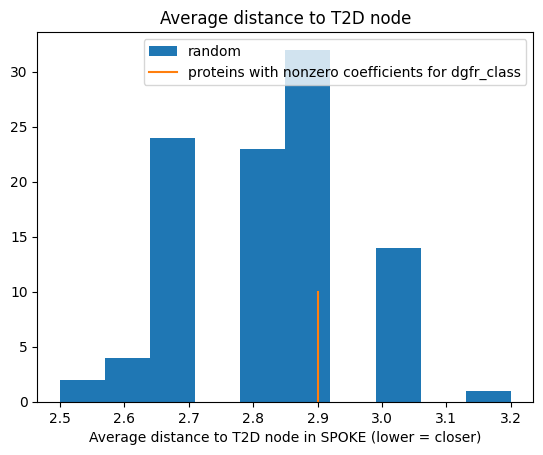

In [225]:
plt.hist(gfr_class_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([gfr_class_stats['average_target_distance'], gfr_class_stats['average_target_distance']],
         [0, 10], label='proteins with nonzero coefficients for dgfr_class')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

#### dGFR all genes

In [226]:
gfr_class_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(gfr_class_gene_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [227]:
gfr_class_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Gene',
                                                            input_id_set=gfr_class_gene_spoke_ids,
                                                            use_degree_sampling=True,
                                                                               len(gfr_class_gene_spoke_ids),
                                                                               target_nodes=[t2d_node_id])

SyntaxError: positional argument follows keyword argument (2461104915.py, line 5)

In [ ]:
gfr_class_null_results = pd.DataFrame(gfr_class_null_results)

In [ ]:
plt.hist(gfr_class_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled genes measured in Arivale')
plt.plot([gfr_class_stats['average_pairwise_distance'], gfr_class_stats['average_pairwise_distance']],
         [0, 10], label='genes with nonzero coefficients for dgfr_class')
plt.xlabel('Average pairwise distance between Arivale genes in SPOKE (lower = more related)')
plt.legend()
plt.tight_layout()
plt.savefig('images_2023_10_18/null_gfr_classification_genes.png', dpi=300)

In [ ]:
plt.hist(gfr_class_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([gfr_class_stats['average_target_distance'], gfr_class_stats['average_target_distance']],
         [0, 10], label='genes with nonzero coefficients for dgfr_class')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()

#### dGFR top 10 genes

In [ ]:
gfr_class_stats = kgfe.explanations.graph_node_stats(spoke_graph_ud_connected,
                                                            list(set(gfr_class_top_gene_spoke_ids)),
                                                            target_nodes=[t2d_node_id])

In [ ]:
gfr_class_null_results = kgfe.explanations.null_graph_stats(spoke_graph_ud_connected, 'Gene',
                                                            input_id_set=gfr_class_top_gene_spoke_ids,
                                                            use_degree_sampling=True,
                                                            len(gfr_class_top_gene_spoke_ids),
                                                            #ids_subset=all_prots_spoke_ids,
                                                            target_nodes=[t2d_node_id])

In [ ]:
gfr_class_null_results = pd.DataFrame(gfr_class_null_results)

In [ ]:
plt.hist(gfr_class_null_results.average_pairwise_distance, bins=10, label='random')
plt.title('Average pairwise distance distribution for randomly sampled proteins measured in Arivale')
plt.plot([gfr_class_stats['average_pairwise_distance'], gfr_class_stats['average_pairwise_distance']],
         [0, 10], label='genes with nonzero coefficients for dgfr_class')
plt.xlabel('Average pairwise distance between Arivale genes in SPOKE (lower = more related)')
plt.legend()

In [ ]:
plt.hist(gfr_class_null_results.average_target_distance, bins=10, label='random')
plt.title('Average distance to T2D node')
plt.plot([gfr_class_stats['average_target_distance'], gfr_class_stats['average_target_distance']],
         [0, 10], label='genes with nonzero coefficients for dgfr_class')
plt.xlabel('Average distance to T2D node in SPOKE (lower = closer)')
plt.legend()